In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

Date   Open   High    Low  Close     Volume  OpenInt
0  2014-09-19  92.70  99.70  89.95  93.89  271831625        0
1  2014-09-22  92.70  92.95  89.50  89.89   66628862        0
2  2014-09-23  89.00  90.48  86.62  87.17   38984872        0
3  2014-09-24  88.47  90.57  87.22  90.57   32016559        0
4  2014-09-25  91.09  91.50  88.50  88.92   28584828        0

**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

## Feature extraction

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

## Reinforcement Learning

### Data Preparation

In [10]:
def train_test_data(ticker, industry_sector, n_tickers, trading_window, min_year=2007, train_max_year=2016):
    
    #Ticker selection
    if ticker is not None:
        tickers = [ticker]
    else:
        #Get list of tickers based on selected industry 
        tickers_lookup = pd.read_csv('tickers_lookup.csv')
        tickers = tickers_lookup[tickers_lookup.INDUSTRY_SECTOR==industry_sector].sort_values('CUR_MKT_CAP',ascending=False)
        tickers = tickers.iloc[:n_tickers]['file_name'] #pick top n tickers by market cap
        tickers = [ticker[:len(ticker)-4] for ticker in tickers] #remove .txt extension
    
    #Empty dataframes to hold full sets of training and test data
    features_train = pd.DataFrame()
    features_test = pd.DataFrame()
    raw_data_train = pd.DataFrame()
    raw_data_test = pd.DataFrame()
    
    for ticker in tickers:
        features_i, raw_data_i = create_features(ticker,trading_window)
        features_i['ticker'] = ticker
        raw_data_i['ticker'] = ticker
        
        #Only keep data after min_year
        features_i['Year'] = pd.to_datetime(features_i.index.values).year
        features_i = features_i.loc[features_i['Year']>min_year]
        raw_data_i = raw_data_i.loc[features_i.index]

        #Split training & testing sets (data points after train_max_year are used for testing)
        features_train_i = features_i.loc[features_i['Year']<train_max_year]
        raw_data_train_i = raw_data_i.loc[features_train_i.index]

        features_test_i = features_i.loc[features_i['Year']>=train_max_year]
        raw_data_test_i = raw_data_i.loc[features_test_i.index]

        #Append to full set of features and raw_data
        features_train = features_train.append(features_train_i)
        raw_data_train = raw_data_train.append(raw_data_train_i)
        features_test = features_test.append(features_test_i)
        raw_data_test = raw_data_test.append(raw_data_test_i)
    
    
    #Remove Year column from features
    features_train = features_train.drop(['Year'], axis = 1)
    features_test = features_test.drop(['Year'], axis = 1)
    
    return features_train, features_test, raw_data_train, raw_data_test

In [11]:
ticker = None
industry_sector = 'Industrial'
n_tickers = 30
trading_window = 21
min_year = 2007
train_max_year = 2016

features_train, features_test, raw_data_train, raw_data_test = train_test_data(ticker,industry_sector,n_tickers,trading_window,min_year,train_max_year)

In [12]:
print('# of total samples: ' + str(features_train.shape[0]+features_test.shape[0]))
print('# of training samples: ' + str(features_train.shape[0]))
print('# of test samples: ' + str(features_test.shape[0]))

# of total samples: 71896
# of training samples: 58025
# of test samples: 13871


### Training

In [13]:
#IPython extension to reload modules, so that kernel does not need to be restarted for every change in the Gym environment
%load_ext autoreload
%autoreload 2

Set up environment for training:

In [14]:
import gym
import gym_market
import numpy as np
import imp

pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 1.04

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_train, 
                  'raw_data':raw_data_train}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [15]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 2, 1, 0, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 2, 0, 0]
Rewards: [-3.55, 0.43999999999999995, 0.39, -0.63, -2.62, 0.32999999999999996, 0.26, -3.74, 0.20999999999999996, -0.81, 0.1200000000000001, -2.86, -3.91, 0.08000000000000007, -1.0699999999999998, 0.030000000000000027, -0.99, -0.05999999999999994, -3.04, -1.19, -1.34]
Return: 0.9707283474046263


In [16]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

Neural net architecture:

In [17]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            
            #self.learning_rate_ = tf.placeholder(tf.float32, shape=[])
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [18]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [62]:
train_episodes = 4000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 1000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [63]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)

Populate memory:

In [64]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [65]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        
        # Decaying learning rate
        #lr_0 = 0.01 
        #lr_i = lr_0*(0.5**(np.floor((1+ep)/500)))
        
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))} #,mainQN.learning_rate_: lr_i
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
              
                print('Episode: {}'.format(ep),
                      'Total reward: {:.2f}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states}) #, mainQN.learning_rate_: lr_i
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions}) #,mainQN.learning_rate_: lr_i
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -22.54 Training loss: 37.7975 Explore P: 0.9979 Total return: 0.98
Episode: 2 Total reward: -31.38 Training loss: 10.1509 Explore P: 0.9959 Total return: 0.95
Episode: 3 Total reward: -40.22 Training loss: 7.5325 Explore P: 0.9938 Total return: 0.91
Episode: 4 Total reward: -21.09 Training loss: 4.1641 Explore P: 0.9917 Total return: 1.02
Episode: 5 Total reward: -22.41 Training loss: 3.6304 Explore P: 0.9897 Total return: 1.12
Episode: 6 Total reward: -24.14 Training loss: 3.4020 Explore P: 0.9876 Total return: 1.06
Episode: 7 Total reward: -30.53 Training loss: 4.5745 Explore P: 0.9856 Total return: 0.90
Episode: 8 Total reward: -34.95 Training loss: 2.8859 Explore P: 0.9835 Total return: 0.97
Episode: 9 Total reward: -17.26 Training loss: 2.1975 Explore P: 0.9815 Total return: 1.02
Episode: 10 Total reward: -32.61 Training loss: 1.8068 Explore P: 0.9794 Total return: 0.93
Episode: 11 Total reward: -32.58 Training loss: 2.8665 Explore P: 0.9774 Total return: 

Episode: 91 Total reward: -27.71 Training loss: 4.0158 Explore P: 0.8278 Total return: 0.99
Episode: 92 Total reward: -28.92 Training loss: 2.7302 Explore P: 0.8261 Total return: 0.99
Episode: 93 Total reward: -25.35 Training loss: 1.9773 Explore P: 0.8244 Total return: 1.02
Episode: 94 Total reward: -21.49 Training loss: 3.7365 Explore P: 0.8227 Total return: 1.03
Episode: 95 Total reward: -24.81 Training loss: 2.9323 Explore P: 0.8209 Total return: 0.99
Episode: 96 Total reward: -28.77 Training loss: 3.9703 Explore P: 0.8192 Total return: 1.00
Episode: 97 Total reward: -14.48 Training loss: 2.7396 Explore P: 0.8175 Total return: 1.03
Episode: 98 Total reward: -24.62 Training loss: 3.3592 Explore P: 0.8159 Total return: 1.05
Episode: 99 Total reward: -48.03 Training loss: 2.9877 Explore P: 0.8142 Total return: 0.96
Episode: 100 Total reward: -28.23 Training loss: 1.6645 Explore P: 0.8125 Total return: 0.98
Episode: 101 Total reward: -29.36 Training loss: 3.1181 Explore P: 0.8108 Total

Episode: 182 Total reward: -30.71 Training loss: 3.7394 Explore P: 0.6855 Total return: 0.92
Episode: 183 Total reward: -17.18 Training loss: 1.6070 Explore P: 0.6841 Total return: 1.02
Episode: 184 Total reward: -20.07 Training loss: 2.4103 Explore P: 0.6827 Total return: 1.03
Episode: 185 Total reward: -38.93 Training loss: 2.5423 Explore P: 0.6813 Total return: 0.94
Episode: 186 Total reward: -22.38 Training loss: 2.8545 Explore P: 0.6799 Total return: 1.01
Episode: 187 Total reward: -24.41 Training loss: 2.9368 Explore P: 0.6785 Total return: 0.99
Episode: 188 Total reward: -31.15 Training loss: 1.7735 Explore P: 0.6771 Total return: 1.04
Episode: 189 Total reward: -40.36 Training loss: 4.5817 Explore P: 0.6757 Total return: 0.92
Episode: 190 Total reward: -13.75 Training loss: 2.2141 Explore P: 0.6743 Total return: 1.08
Episode: 191 Total reward: -34.88 Training loss: 3.4215 Explore P: 0.6729 Total return: 0.86
Episode: 192 Total reward: -20.81 Training loss: 2.3567 Explore P: 0.6

Episode: 271 Total reward: -22.56 Training loss: 3.0298 Explore P: 0.5704 Total return: 1.26
Episode: 272 Total reward: -23.85 Training loss: 2.2129 Explore P: 0.5692 Total return: 1.00
Episode: 273 Total reward: -22.74 Training loss: 2.4809 Explore P: 0.5680 Total return: 1.01
Episode: 274 Total reward: -30.75 Training loss: 1.2039 Explore P: 0.5669 Total return: 0.94
Episode: 275 Total reward: -11.85 Training loss: 0.8863 Explore P: 0.5657 Total return: 1.07
Episode: 276 Total reward: -21.18 Training loss: 2.4333 Explore P: 0.5645 Total return: 1.03
Episode: 277 Total reward: -33.31 Training loss: 2.0788 Explore P: 0.5634 Total return: 0.93
Episode: 278 Total reward: -22.06 Training loss: 2.3122 Explore P: 0.5622 Total return: 1.00
Episode: 279 Total reward: -33.58 Training loss: 2.2179 Explore P: 0.5610 Total return: 0.96
Episode: 280 Total reward: -29.24 Training loss: 3.1866 Explore P: 0.5599 Total return: 0.97
Episode: 281 Total reward: -22.50 Training loss: 2.4568 Explore P: 0.5

Episode: 360 Total reward: -19.32 Training loss: 3.1310 Explore P: 0.4748 Total return: 1.01
Episode: 361 Total reward: -25.44 Training loss: 4.7505 Explore P: 0.4739 Total return: 1.00
Episode: 362 Total reward: -26.05 Training loss: 1.8534 Explore P: 0.4729 Total return: 0.99
Episode: 363 Total reward: -22.08 Training loss: 0.7327 Explore P: 0.4719 Total return: 1.03
Episode: 364 Total reward: -21.88 Training loss: 2.3756 Explore P: 0.4710 Total return: 1.03
Episode: 365 Total reward: -30.84 Training loss: 1.1315 Explore P: 0.4700 Total return: 1.11
Episode: 366 Total reward: -17.84 Training loss: 2.5199 Explore P: 0.4690 Total return: 1.23
Episode: 367 Total reward: -21.06 Training loss: 2.0558 Explore P: 0.4681 Total return: 1.01
Episode: 368 Total reward: -41.12 Training loss: 3.0096 Explore P: 0.4671 Total return: 0.99
Episode: 369 Total reward: -30.66 Training loss: 2.4481 Explore P: 0.4661 Total return: 1.01
Episode: 370 Total reward: -22.40 Training loss: 3.2159 Explore P: 0.4

Episode: 451 Total reward: -31.53 Training loss: 2.8270 Explore P: 0.3940 Total return: 1.01
Episode: 452 Total reward: -19.42 Training loss: 1.7134 Explore P: 0.3932 Total return: 1.02
Episode: 453 Total reward: -34.47 Training loss: 1.5413 Explore P: 0.3924 Total return: 0.95
Episode: 454 Total reward: -22.03 Training loss: 1.3599 Explore P: 0.3916 Total return: 1.03
Episode: 455 Total reward: -21.71 Training loss: 2.5948 Explore P: 0.3908 Total return: 1.04
Episode: 456 Total reward: -25.80 Training loss: 2.2357 Explore P: 0.3900 Total return: 1.01
Episode: 457 Total reward: -18.73 Training loss: 2.1663 Explore P: 0.3892 Total return: 1.04
Episode: 458 Total reward: -18.51 Training loss: 1.4217 Explore P: 0.3884 Total return: 1.06
Episode: 459 Total reward: -29.31 Training loss: 2.1246 Explore P: 0.3876 Total return: 0.94
Episode: 460 Total reward: -27.18 Training loss: 2.3113 Explore P: 0.3868 Total return: 0.99
Episode: 461 Total reward: -20.78 Training loss: 1.4485 Explore P: 0.3

Episode: 542 Total reward: -19.48 Training loss: 2.6452 Explore P: 0.3272 Total return: 1.00
Episode: 543 Total reward: -21.71 Training loss: 1.2888 Explore P: 0.3265 Total return: 1.02
Episode: 544 Total reward: -34.78 Training loss: 2.8368 Explore P: 0.3259 Total return: 0.96
Episode: 545 Total reward: -23.61 Training loss: 2.6984 Explore P: 0.3252 Total return: 1.06
Episode: 546 Total reward: -23.97 Training loss: 1.9378 Explore P: 0.3245 Total return: 0.99
Episode: 547 Total reward: -26.70 Training loss: 2.7107 Explore P: 0.3239 Total return: 1.00
Episode: 548 Total reward: -12.21 Training loss: 1.9497 Explore P: 0.3232 Total return: 1.10
Episode: 549 Total reward: -12.33 Training loss: 1.8041 Explore P: 0.3226 Total return: 1.03
Episode: 550 Total reward: -35.18 Training loss: 1.7490 Explore P: 0.3219 Total return: 0.94
Episode: 551 Total reward: -23.66 Training loss: 0.9962 Explore P: 0.3213 Total return: 0.99
Episode: 552 Total reward: -21.87 Training loss: 1.8161 Explore P: 0.3

Episode: 632 Total reward: -30.79 Training loss: 1.3287 Explore P: 0.2726 Total return: 0.93
Episode: 633 Total reward: -24.55 Training loss: 1.6859 Explore P: 0.2720 Total return: 0.98
Episode: 634 Total reward: -21.72 Training loss: 2.2182 Explore P: 0.2715 Total return: 0.92
Episode: 635 Total reward: -19.74 Training loss: 2.3888 Explore P: 0.2709 Total return: 1.12
Episode: 636 Total reward: -20.71 Training loss: 2.2622 Explore P: 0.2704 Total return: 1.09
Episode: 637 Total reward: -15.38 Training loss: 1.9772 Explore P: 0.2698 Total return: 0.96
Episode: 638 Total reward: -33.11 Training loss: 2.3348 Explore P: 0.2693 Total return: 0.88
Episode: 639 Total reward: -26.63 Training loss: 2.3163 Explore P: 0.2687 Total return: 0.91
Episode: 640 Total reward: -19.34 Training loss: 1.4892 Explore P: 0.2682 Total return: 0.97
Episode: 641 Total reward: -21.10 Training loss: 1.3443 Explore P: 0.2677 Total return: 0.94
Episode: 642 Total reward: -16.08 Training loss: 2.4574 Explore P: 0.2

Episode: 722 Total reward: -16.08 Training loss: 1.2830 Explore P: 0.2273 Total return: 1.07
Episode: 723 Total reward: -18.33 Training loss: 2.0012 Explore P: 0.2269 Total return: 1.02
Episode: 724 Total reward: -22.86 Training loss: 1.3335 Explore P: 0.2264 Total return: 1.12
Episode: 725 Total reward: -29.22 Training loss: 1.9303 Explore P: 0.2260 Total return: 0.98
Episode: 726 Total reward: -28.05 Training loss: 2.1923 Explore P: 0.2255 Total return: 0.97
Episode: 727 Total reward: -22.85 Training loss: 2.9736 Explore P: 0.2251 Total return: 0.98
Episode: 728 Total reward: -32.19 Training loss: 2.4216 Explore P: 0.2246 Total return: 0.88
Episode: 729 Total reward: -12.46 Training loss: 2.2226 Explore P: 0.2242 Total return: 0.98
Episode: 730 Total reward: -19.90 Training loss: 2.4183 Explore P: 0.2237 Total return: 0.93
Episode: 731 Total reward: -24.27 Training loss: 1.5139 Explore P: 0.2233 Total return: 1.05
Episode: 732 Total reward: -24.13 Training loss: 2.8018 Explore P: 0.2

Episode: 812 Total reward: -28.77 Training loss: 0.8194 Explore P: 0.1899 Total return: 1.00
Episode: 813 Total reward: -28.11 Training loss: 2.3647 Explore P: 0.1895 Total return: 0.89
Episode: 814 Total reward: -28.69 Training loss: 0.8139 Explore P: 0.1892 Total return: 0.98
Episode: 815 Total reward: -15.49 Training loss: 3.2411 Explore P: 0.1888 Total return: 1.01
Episode: 816 Total reward: -20.20 Training loss: 2.4157 Explore P: 0.1884 Total return: 1.08
Episode: 817 Total reward: -26.53 Training loss: 1.7028 Explore P: 0.1880 Total return: 0.95
Episode: 818 Total reward: -9.02 Training loss: 2.1479 Explore P: 0.1877 Total return: 1.12
Episode: 819 Total reward: -15.43 Training loss: 1.3764 Explore P: 0.1873 Total return: 1.02
Episode: 820 Total reward: -21.88 Training loss: 1.0817 Explore P: 0.1869 Total return: 1.02
Episode: 821 Total reward: -26.07 Training loss: 1.8671 Explore P: 0.1866 Total return: 0.94
Episode: 822 Total reward: -19.57 Training loss: 1.0715 Explore P: 0.18

Episode: 902 Total reward: -32.65 Training loss: 3.2080 Explore P: 0.1589 Total return: 0.92
Episode: 903 Total reward: -12.56 Training loss: 2.9735 Explore P: 0.1586 Total return: 1.06
Episode: 904 Total reward: -29.01 Training loss: 2.0611 Explore P: 0.1583 Total return: 1.05
Episode: 905 Total reward: -19.61 Training loss: 1.5984 Explore P: 0.1580 Total return: 1.03
Episode: 906 Total reward: -23.58 Training loss: 1.1892 Explore P: 0.1577 Total return: 1.01
Episode: 907 Total reward: -24.18 Training loss: 2.2144 Explore P: 0.1574 Total return: 0.99
Episode: 908 Total reward: -24.88 Training loss: 2.2743 Explore P: 0.1571 Total return: 1.20
Episode: 909 Total reward: -22.16 Training loss: 2.7722 Explore P: 0.1568 Total return: 0.96
Episode: 910 Total reward: -30.51 Training loss: 2.5608 Explore P: 0.1565 Total return: 0.98
Episode: 911 Total reward: -16.66 Training loss: 1.6160 Explore P: 0.1561 Total return: 1.01
Episode: 912 Total reward: -37.90 Training loss: 1.0296 Explore P: 0.1

Episode: 991 Total reward: -28.72 Training loss: 2.3635 Explore P: 0.1335 Total return: 1.07
Episode: 992 Total reward: -24.57 Training loss: 1.8078 Explore P: 0.1333 Total return: 0.84
Episode: 993 Total reward: -34.16 Training loss: 1.4699 Explore P: 0.1330 Total return: 0.98
Episode: 994 Total reward: -31.36 Training loss: 2.1266 Explore P: 0.1328 Total return: 1.01
Episode: 995 Total reward: -27.27 Training loss: 1.3180 Explore P: 0.1325 Total return: 1.09
Episode: 996 Total reward: -25.35 Training loss: 3.7899 Explore P: 0.1323 Total return: 1.05
Episode: 997 Total reward: -17.60 Training loss: 1.8350 Explore P: 0.1320 Total return: 1.08
Episode: 998 Total reward: -40.46 Training loss: 1.8627 Explore P: 0.1317 Total return: 0.93
Episode: 999 Total reward: -21.17 Training loss: 1.9064 Explore P: 0.1315 Total return: 1.03
Episode: 1000 Total reward: -22.27 Training loss: 1.5204 Explore P: 0.1312 Total return: 1.00
Episode: 1001 Total reward: -35.73 Training loss: 2.6559 Explore P: 0

Episode: 1081 Total reward: -21.87 Training loss: 2.9567 Explore P: 0.1123 Total return: 1.02
Episode: 1082 Total reward: -26.34 Training loss: 1.1403 Explore P: 0.1121 Total return: 1.01
Episode: 1083 Total reward: -16.96 Training loss: 1.3405 Explore P: 0.1118 Total return: 1.04
Episode: 1084 Total reward: -20.70 Training loss: 2.8477 Explore P: 0.1116 Total return: 1.10
Episode: 1085 Total reward: -21.60 Training loss: 2.9722 Explore P: 0.1114 Total return: 0.99
Episode: 1086 Total reward: -23.59 Training loss: 1.2932 Explore P: 0.1112 Total return: 0.98
Episode: 1087 Total reward: -37.52 Training loss: 2.6853 Explore P: 0.1110 Total return: 0.95
Episode: 1088 Total reward: -20.23 Training loss: 1.5994 Explore P: 0.1108 Total return: 1.06
Episode: 1089 Total reward: -18.12 Training loss: 2.5986 Explore P: 0.1106 Total return: 1.15
Episode: 1090 Total reward: -33.39 Training loss: 1.7132 Explore P: 0.1104 Total return: 1.03
Episode: 1091 Total reward: -18.54 Training loss: 2.0061 Exp

Episode: 1171 Total reward: -17.10 Training loss: 1.0858 Explore P: 0.0947 Total return: 1.04
Episode: 1172 Total reward: -22.41 Training loss: 2.0158 Explore P: 0.0945 Total return: 1.08
Episode: 1173 Total reward: -29.62 Training loss: 2.0888 Explore P: 0.0943 Total return: 1.03
Episode: 1174 Total reward: -27.98 Training loss: 1.5210 Explore P: 0.0941 Total return: 0.98
Episode: 1175 Total reward: -47.46 Training loss: 1.5781 Explore P: 0.0939 Total return: 0.87
Episode: 1176 Total reward: -30.56 Training loss: 3.6668 Explore P: 0.0938 Total return: 0.96
Episode: 1177 Total reward: -11.89 Training loss: 1.8757 Explore P: 0.0936 Total return: 1.12
Episode: 1178 Total reward: -27.12 Training loss: 2.4998 Explore P: 0.0934 Total return: 1.01
Episode: 1179 Total reward: -26.55 Training loss: 2.8559 Explore P: 0.0932 Total return: 0.95
Episode: 1180 Total reward: -29.36 Training loss: 3.1187 Explore P: 0.0931 Total return: 0.93
Episode: 1181 Total reward: -45.15 Training loss: 2.0236 Exp

Episode: 1261 Total reward: -16.96 Training loss: 2.9464 Explore P: 0.0801 Total return: 1.00
Episode: 1262 Total reward: -25.69 Training loss: 1.5603 Explore P: 0.0799 Total return: 0.97
Episode: 1263 Total reward: -18.88 Training loss: 2.5204 Explore P: 0.0798 Total return: 1.00
Episode: 1264 Total reward: -26.88 Training loss: 1.5799 Explore P: 0.0796 Total return: 0.97
Episode: 1265 Total reward: -41.62 Training loss: 1.8942 Explore P: 0.0795 Total return: 1.05
Episode: 1266 Total reward: -22.57 Training loss: 2.3127 Explore P: 0.0793 Total return: 1.00
Episode: 1267 Total reward: -15.95 Training loss: 1.2867 Explore P: 0.0792 Total return: 1.00
Episode: 1268 Total reward: -26.95 Training loss: 1.7211 Explore P: 0.0791 Total return: 0.98
Episode: 1269 Total reward: -25.47 Training loss: 1.3057 Explore P: 0.0789 Total return: 0.96
Episode: 1270 Total reward: -20.25 Training loss: 1.3323 Explore P: 0.0788 Total return: 0.98
Episode: 1271 Total reward: -17.05 Training loss: 2.3761 Exp

Episode: 1351 Total reward: -29.07 Training loss: 1.5549 Explore P: 0.0680 Total return: 1.00
Episode: 1352 Total reward: -18.19 Training loss: 1.9213 Explore P: 0.0679 Total return: 1.11
Episode: 1353 Total reward: -32.21 Training loss: 1.4432 Explore P: 0.0678 Total return: 0.93
Episode: 1354 Total reward: -12.42 Training loss: 0.4382 Explore P: 0.0676 Total return: 1.03
Episode: 1355 Total reward: -21.02 Training loss: 0.9889 Explore P: 0.0675 Total return: 0.97
Episode: 1356 Total reward: -30.00 Training loss: 1.5265 Explore P: 0.0674 Total return: 0.94
Episode: 1357 Total reward: -27.29 Training loss: 1.2499 Explore P: 0.0673 Total return: 0.99
Episode: 1358 Total reward: -16.29 Training loss: 1.7742 Explore P: 0.0672 Total return: 1.03
Episode: 1359 Total reward: -20.48 Training loss: 1.3305 Explore P: 0.0670 Total return: 0.99
Episode: 1360 Total reward: -20.91 Training loss: 0.3757 Explore P: 0.0669 Total return: 0.96
Episode: 1361 Total reward: -16.95 Training loss: 0.3527 Exp

Episode: 1440 Total reward: -14.94 Training loss: 1.3346 Explore P: 0.0581 Total return: 1.06
Episode: 1441 Total reward: -19.03 Training loss: 1.4681 Explore P: 0.0580 Total return: 0.98
Episode: 1442 Total reward: -22.19 Training loss: 2.2905 Explore P: 0.0579 Total return: 0.98
Episode: 1443 Total reward: -14.75 Training loss: 1.1366 Explore P: 0.0578 Total return: 1.03
Episode: 1444 Total reward: -14.72 Training loss: 2.3692 Explore P: 0.0577 Total return: 0.94
Episode: 1445 Total reward: -20.78 Training loss: 1.0116 Explore P: 0.0576 Total return: 0.98
Episode: 1446 Total reward: -15.94 Training loss: 0.9329 Explore P: 0.0575 Total return: 1.04
Episode: 1447 Total reward: -18.38 Training loss: 2.2168 Explore P: 0.0574 Total return: 1.06
Episode: 1448 Total reward: -18.91 Training loss: 1.8126 Explore P: 0.0573 Total return: 1.07
Episode: 1449 Total reward: -21.90 Training loss: 3.0422 Explore P: 0.0572 Total return: 1.02
Episode: 1450 Total reward: -24.88 Training loss: 1.7947 Exp

Episode: 1529 Total reward: -30.81 Training loss: 1.6111 Explore P: 0.0499 Total return: 0.96
Episode: 1530 Total reward: -31.20 Training loss: 1.4976 Explore P: 0.0498 Total return: 0.94
Episode: 1531 Total reward: -13.01 Training loss: 1.6725 Explore P: 0.0497 Total return: 1.03
Episode: 1532 Total reward: -15.45 Training loss: 3.0437 Explore P: 0.0497 Total return: 1.01
Episode: 1533 Total reward: -18.78 Training loss: 1.0934 Explore P: 0.0496 Total return: 1.01
Episode: 1534 Total reward: -30.23 Training loss: 1.5884 Explore P: 0.0495 Total return: 0.92
Episode: 1535 Total reward: -24.00 Training loss: 1.7192 Explore P: 0.0494 Total return: 1.07
Episode: 1536 Total reward: -21.82 Training loss: 1.4928 Explore P: 0.0493 Total return: 0.99
Episode: 1537 Total reward: -21.41 Training loss: 2.4429 Explore P: 0.0493 Total return: 1.01
Episode: 1538 Total reward: -26.17 Training loss: 1.3985 Explore P: 0.0492 Total return: 0.99
Episode: 1539 Total reward: -13.80 Training loss: 1.7806 Exp

Episode: 1619 Total reward: -21.89 Training loss: 1.7539 Explore P: 0.0430 Total return: 1.06
Episode: 1620 Total reward: -31.67 Training loss: 1.4280 Explore P: 0.0430 Total return: 0.95
Episode: 1621 Total reward: -32.10 Training loss: 0.9307 Explore P: 0.0429 Total return: 0.95
Episode: 1622 Total reward: -32.84 Training loss: 2.4955 Explore P: 0.0428 Total return: 0.89
Episode: 1623 Total reward: -16.41 Training loss: 1.1891 Explore P: 0.0428 Total return: 1.03
Episode: 1624 Total reward: -18.22 Training loss: 2.7725 Explore P: 0.0427 Total return: 1.05
Episode: 1625 Total reward: -24.09 Training loss: 1.7168 Explore P: 0.0426 Total return: 0.97
Episode: 1626 Total reward: -36.82 Training loss: 1.0140 Explore P: 0.0426 Total return: 0.90
Episode: 1627 Total reward: -20.83 Training loss: 1.9412 Explore P: 0.0425 Total return: 1.01
Episode: 1628 Total reward: -18.05 Training loss: 2.1622 Explore P: 0.0424 Total return: 1.04
Episode: 1629 Total reward: -15.50 Training loss: 0.3110 Exp

Episode: 1708 Total reward: -22.92 Training loss: 1.3148 Explore P: 0.0374 Total return: 0.99
Episode: 1709 Total reward: -13.95 Training loss: 2.0391 Explore P: 0.0374 Total return: 1.06
Episode: 1710 Total reward: -13.95 Training loss: 2.2478 Explore P: 0.0373 Total return: 1.06
Episode: 1711 Total reward: -24.92 Training loss: 0.9446 Explore P: 0.0372 Total return: 1.01
Episode: 1712 Total reward: -16.88 Training loss: 0.9009 Explore P: 0.0372 Total return: 1.09
Episode: 1713 Total reward: -13.90 Training loss: 1.8554 Explore P: 0.0371 Total return: 1.06
Episode: 1714 Total reward: -20.63 Training loss: 0.5524 Explore P: 0.0371 Total return: 1.06
Episode: 1715 Total reward: -17.62 Training loss: 1.5195 Explore P: 0.0370 Total return: 1.03
Episode: 1716 Total reward: -32.65 Training loss: 1.6022 Explore P: 0.0370 Total return: 0.95
Episode: 1717 Total reward: -15.52 Training loss: 2.0151 Explore P: 0.0369 Total return: 1.07
Episode: 1718 Total reward: -23.28 Training loss: 1.7846 Exp

Episode: 1797 Total reward: -14.75 Training loss: 1.0726 Explore P: 0.0327 Total return: 1.02
Episode: 1798 Total reward: -15.47 Training loss: 1.5580 Explore P: 0.0327 Total return: 1.11
Episode: 1799 Total reward: -14.48 Training loss: 1.6296 Explore P: 0.0326 Total return: 1.09
Episode: 1800 Total reward: -16.26 Training loss: 1.4017 Explore P: 0.0326 Total return: 1.02
Episode: 1801 Total reward: -14.45 Training loss: 2.3056 Explore P: 0.0325 Total return: 1.04
Episode: 1802 Total reward: -29.68 Training loss: 1.3101 Explore P: 0.0325 Total return: 0.91
Episode: 1803 Total reward: -15.57 Training loss: 2.6796 Explore P: 0.0325 Total return: 1.07
Episode: 1804 Total reward: -20.55 Training loss: 0.9954 Explore P: 0.0324 Total return: 1.06
Episode: 1805 Total reward: -17.96 Training loss: 1.5766 Explore P: 0.0324 Total return: 1.07
Episode: 1806 Total reward: -16.47 Training loss: 2.1628 Explore P: 0.0323 Total return: 1.05
Episode: 1807 Total reward: -23.04 Training loss: 1.0096 Exp

Episode: 1887 Total reward: -16.50 Training loss: 1.8023 Explore P: 0.0288 Total return: 1.02
Episode: 1888 Total reward: -13.49 Training loss: 2.4315 Explore P: 0.0288 Total return: 1.04
Episode: 1889 Total reward: -25.85 Training loss: 1.1935 Explore P: 0.0287 Total return: 0.97
Episode: 1890 Total reward: -21.24 Training loss: 1.7228 Explore P: 0.0287 Total return: 0.95
Episode: 1891 Total reward: -15.27 Training loss: 1.5759 Explore P: 0.0287 Total return: 1.08
Episode: 1892 Total reward: -14.88 Training loss: 0.7866 Explore P: 0.0286 Total return: 1.02
Episode: 1893 Total reward: -17.83 Training loss: 2.3787 Explore P: 0.0286 Total return: 0.95
Episode: 1894 Total reward: -14.35 Training loss: 1.0928 Explore P: 0.0285 Total return: 1.10
Episode: 1895 Total reward: -29.55 Training loss: 0.5019 Explore P: 0.0285 Total return: 0.94
Episode: 1896 Total reward: -18.05 Training loss: 2.0238 Explore P: 0.0285 Total return: 1.05
Episode: 1897 Total reward: -18.68 Training loss: 3.8053 Exp

Episode: 1976 Total reward: -29.12 Training loss: 1.5367 Explore P: 0.0256 Total return: 1.05
Episode: 1977 Total reward: -21.79 Training loss: 1.1961 Explore P: 0.0256 Total return: 1.00
Episode: 1978 Total reward: -21.07 Training loss: 0.6467 Explore P: 0.0255 Total return: 1.01
Episode: 1979 Total reward: -17.68 Training loss: 0.8932 Explore P: 0.0255 Total return: 1.04
Episode: 1980 Total reward: -17.08 Training loss: 0.2743 Explore P: 0.0255 Total return: 1.04
Episode: 1981 Total reward: -14.02 Training loss: 1.9171 Explore P: 0.0254 Total return: 1.04
Episode: 1982 Total reward: -18.52 Training loss: 1.5635 Explore P: 0.0254 Total return: 0.99
Episode: 1983 Total reward: -14.76 Training loss: 0.9855 Explore P: 0.0254 Total return: 1.11
Episode: 1984 Total reward: -19.58 Training loss: 0.8015 Explore P: 0.0254 Total return: 1.00
Episode: 1985 Total reward: -13.57 Training loss: 1.1335 Explore P: 0.0253 Total return: 1.02
Episode: 1986 Total reward: -12.43 Training loss: 1.1661 Exp

Episode: 2066 Total reward: -17.63 Training loss: 0.5511 Explore P: 0.0229 Total return: 1.03
Episode: 2067 Total reward: -28.92 Training loss: 1.2142 Explore P: 0.0229 Total return: 0.98
Episode: 2068 Total reward: -23.28 Training loss: 1.1289 Explore P: 0.0229 Total return: 0.98
Episode: 2069 Total reward: -14.32 Training loss: 1.2679 Explore P: 0.0228 Total return: 1.00
Episode: 2070 Total reward: -19.83 Training loss: 0.7322 Explore P: 0.0228 Total return: 0.97
Episode: 2071 Total reward: -20.42 Training loss: 0.9831 Explore P: 0.0228 Total return: 1.03
Episode: 2072 Total reward: -15.82 Training loss: 1.7246 Explore P: 0.0228 Total return: 1.04
Episode: 2073 Total reward: -32.50 Training loss: 1.9129 Explore P: 0.0227 Total return: 1.00
Episode: 2074 Total reward: -21.18 Training loss: 0.9800 Explore P: 0.0227 Total return: 0.97
Episode: 2075 Total reward: -16.02 Training loss: 0.9032 Explore P: 0.0227 Total return: 0.98
Episode: 2076 Total reward: -16.86 Training loss: 1.0487 Exp

Episode: 2156 Total reward: -27.11 Training loss: 0.5633 Explore P: 0.0207 Total return: 0.95
Episode: 2157 Total reward: -22.00 Training loss: 0.6074 Explore P: 0.0207 Total return: 1.00
Episode: 2158 Total reward: -14.45 Training loss: 1.3284 Explore P: 0.0207 Total return: 1.04
Episode: 2159 Total reward: -16.56 Training loss: 1.6398 Explore P: 0.0206 Total return: 1.03
Episode: 2160 Total reward: -14.52 Training loss: 1.3094 Explore P: 0.0206 Total return: 1.04
Episode: 2161 Total reward: -14.52 Training loss: 0.5533 Explore P: 0.0206 Total return: 1.01
Episode: 2162 Total reward: -16.23 Training loss: 1.1359 Explore P: 0.0206 Total return: 1.05
Episode: 2163 Total reward: -18.35 Training loss: 0.3443 Explore P: 0.0205 Total return: 1.00
Episode: 2164 Total reward: -28.98 Training loss: 1.2480 Explore P: 0.0205 Total return: 0.94
Episode: 2165 Total reward: -18.75 Training loss: 0.3905 Explore P: 0.0205 Total return: 0.93
Episode: 2166 Total reward: -18.15 Training loss: 0.4265 Exp

Episode: 2244 Total reward: -18.45 Training loss: 1.0671 Explore P: 0.0189 Total return: 0.99
Episode: 2245 Total reward: -18.56 Training loss: 0.9079 Explore P: 0.0189 Total return: 1.00
Episode: 2246 Total reward: -14.57 Training loss: 1.0134 Explore P: 0.0189 Total return: 1.08
Episode: 2247 Total reward: -24.70 Training loss: 1.3207 Explore P: 0.0188 Total return: 0.93
Episode: 2248 Total reward: -23.00 Training loss: 1.2314 Explore P: 0.0188 Total return: 0.99
Episode: 2249 Total reward: -11.03 Training loss: 2.1757 Explore P: 0.0188 Total return: 1.09
Episode: 2250 Total reward: -22.19 Training loss: 0.1490 Explore P: 0.0188 Total return: 0.94
Episode: 2251 Total reward: -14.45 Training loss: 0.3159 Explore P: 0.0188 Total return: 1.02
Episode: 2252 Total reward: -14.93 Training loss: 1.9522 Explore P: 0.0187 Total return: 1.06
Episode: 2253 Total reward: -21.55 Training loss: 0.7998 Explore P: 0.0187 Total return: 0.96
Episode: 2254 Total reward: -18.20 Training loss: 1.2375 Exp

Episode: 2334 Total reward: -16.59 Training loss: 1.8007 Explore P: 0.0174 Total return: 1.05
Episode: 2335 Total reward: -16.86 Training loss: 1.7129 Explore P: 0.0173 Total return: 1.02
Episode: 2336 Total reward: -22.70 Training loss: 1.1592 Explore P: 0.0173 Total return: 0.96
Episode: 2337 Total reward: -24.06 Training loss: 0.8787 Explore P: 0.0173 Total return: 0.96
Episode: 2338 Total reward: -16.41 Training loss: 0.3197 Explore P: 0.0173 Total return: 0.97
Episode: 2339 Total reward: -15.85 Training loss: 0.5137 Explore P: 0.0173 Total return: 1.02
Episode: 2340 Total reward: -18.19 Training loss: 0.8231 Explore P: 0.0173 Total return: 1.04
Episode: 2341 Total reward: -14.45 Training loss: 0.0259 Explore P: 0.0173 Total return: 1.03
Episode: 2342 Total reward: -15.78 Training loss: 1.5996 Explore P: 0.0172 Total return: 1.07
Episode: 2343 Total reward: -21.52 Training loss: 0.4979 Explore P: 0.0172 Total return: 1.11
Episode: 2344 Total reward: -17.82 Training loss: 0.9911 Exp

Episode: 2424 Total reward: -31.32 Training loss: 0.6559 Explore P: 0.0161 Total return: 0.97
Episode: 2425 Total reward: -23.88 Training loss: 1.7287 Explore P: 0.0161 Total return: 0.98
Episode: 2426 Total reward: -22.13 Training loss: 0.8628 Explore P: 0.0161 Total return: 1.01
Episode: 2427 Total reward: -19.30 Training loss: 0.5274 Explore P: 0.0161 Total return: 1.14
Episode: 2428 Total reward: -26.58 Training loss: 0.8512 Explore P: 0.0160 Total return: 1.04
Episode: 2429 Total reward: -14.22 Training loss: 1.4556 Explore P: 0.0160 Total return: 0.97
Episode: 2430 Total reward: -22.39 Training loss: 1.2611 Explore P: 0.0160 Total return: 1.05
Episode: 2431 Total reward: -16.92 Training loss: 1.4330 Explore P: 0.0160 Total return: 1.03
Episode: 2432 Total reward: -33.48 Training loss: 1.7201 Explore P: 0.0160 Total return: 1.05
Episode: 2433 Total reward: -27.03 Training loss: 0.6770 Explore P: 0.0160 Total return: 1.03
Episode: 2434 Total reward: -14.13 Training loss: 0.5874 Exp

Episode: 2513 Total reward: -10.14 Training loss: 1.3609 Explore P: 0.0151 Total return: 1.05
Episode: 2514 Total reward: -22.22 Training loss: 0.6901 Explore P: 0.0150 Total return: 1.06
Episode: 2515 Total reward: -20.18 Training loss: 0.2521 Explore P: 0.0150 Total return: 1.03
Episode: 2516 Total reward: -19.07 Training loss: 0.9968 Explore P: 0.0150 Total return: 0.95
Episode: 2517 Total reward: -18.63 Training loss: 1.8695 Explore P: 0.0150 Total return: 1.00
Episode: 2518 Total reward: -14.49 Training loss: 1.7262 Explore P: 0.0150 Total return: 1.05
Episode: 2519 Total reward: -18.70 Training loss: 1.6314 Explore P: 0.0150 Total return: 1.04
Episode: 2520 Total reward: -19.85 Training loss: 1.3939 Explore P: 0.0150 Total return: 1.03
Episode: 2521 Total reward: -14.10 Training loss: 0.4952 Explore P: 0.0150 Total return: 1.07
Episode: 2522 Total reward: -20.65 Training loss: 0.4176 Explore P: 0.0150 Total return: 1.01
Episode: 2523 Total reward: -14.87 Training loss: 0.7575 Exp

Episode: 2601 Total reward: -22.13 Training loss: 2.0438 Explore P: 0.0142 Total return: 1.01
Episode: 2602 Total reward: -14.31 Training loss: 2.5422 Explore P: 0.0142 Total return: 1.01
Episode: 2603 Total reward: -28.78 Training loss: 0.5254 Explore P: 0.0142 Total return: 0.98
Episode: 2604 Total reward: -24.28 Training loss: 1.5268 Explore P: 0.0142 Total return: 1.02
Episode: 2605 Total reward: -14.13 Training loss: 1.6082 Explore P: 0.0142 Total return: 1.09
Episode: 2606 Total reward: -16.39 Training loss: 1.3211 Explore P: 0.0142 Total return: 1.09
Episode: 2607 Total reward: -16.61 Training loss: 0.8546 Explore P: 0.0141 Total return: 1.06
Episode: 2608 Total reward: -17.13 Training loss: 1.1730 Explore P: 0.0141 Total return: 1.00
Episode: 2609 Total reward: -24.75 Training loss: 1.3270 Explore P: 0.0141 Total return: 0.93
Episode: 2610 Total reward: -13.97 Training loss: 1.1098 Explore P: 0.0141 Total return: 1.07
Episode: 2611 Total reward: -20.80 Training loss: 1.0693 Exp

Episode: 2689 Total reward: -35.04 Training loss: 0.6845 Explore P: 0.0135 Total return: 0.99
Episode: 2690 Total reward: -15.10 Training loss: 1.4240 Explore P: 0.0135 Total return: 1.10
Episode: 2691 Total reward: -19.35 Training loss: 0.5078 Explore P: 0.0135 Total return: 0.98
Episode: 2692 Total reward: -17.97 Training loss: 2.1806 Explore P: 0.0135 Total return: 1.04
Episode: 2693 Total reward: -15.94 Training loss: 1.1287 Explore P: 0.0135 Total return: 1.04
Episode: 2694 Total reward: -18.08 Training loss: 0.7860 Explore P: 0.0135 Total return: 1.07
Episode: 2695 Total reward: -19.31 Training loss: 0.5356 Explore P: 0.0134 Total return: 0.99
Episode: 2696 Total reward: -21.08 Training loss: 0.3740 Explore P: 0.0134 Total return: 0.97
Episode: 2697 Total reward: -40.34 Training loss: 0.5628 Explore P: 0.0134 Total return: 0.80
Episode: 2698 Total reward: -24.33 Training loss: 0.5638 Explore P: 0.0134 Total return: 1.02
Episode: 2699 Total reward: -16.84 Training loss: 1.1921 Exp

Episode: 2777 Total reward: -18.45 Training loss: 0.6464 Explore P: 0.0129 Total return: 1.09
Episode: 2778 Total reward: -22.32 Training loss: 1.9584 Explore P: 0.0129 Total return: 0.98
Episode: 2779 Total reward: -16.15 Training loss: 0.4546 Explore P: 0.0129 Total return: 1.05
Episode: 2780 Total reward: -14.75 Training loss: 0.2353 Explore P: 0.0129 Total return: 1.02
Episode: 2781 Total reward: -15.66 Training loss: 0.4432 Explore P: 0.0129 Total return: 1.04
Episode: 2782 Total reward: -12.64 Training loss: 1.2451 Explore P: 0.0129 Total return: 1.09
Episode: 2783 Total reward: -39.31 Training loss: 0.9956 Explore P: 0.0129 Total return: 0.94
Episode: 2784 Total reward: -17.27 Training loss: 0.9716 Explore P: 0.0129 Total return: 0.97
Episode: 2785 Total reward: -18.40 Training loss: 1.6086 Explore P: 0.0129 Total return: 1.04
Episode: 2786 Total reward: -18.07 Training loss: 2.2857 Explore P: 0.0128 Total return: 1.00
Episode: 2787 Total reward: -24.50 Training loss: 0.8429 Exp

Episode: 2865 Total reward: -16.10 Training loss: 1.3205 Explore P: 0.0124 Total return: 1.01
Episode: 2866 Total reward: -20.50 Training loss: 1.1032 Explore P: 0.0124 Total return: 0.99
Episode: 2867 Total reward: -15.12 Training loss: 0.4184 Explore P: 0.0124 Total return: 1.11
Episode: 2868 Total reward: -17.99 Training loss: 1.3102 Explore P: 0.0124 Total return: 1.04
Episode: 2869 Total reward: -19.27 Training loss: 0.7818 Explore P: 0.0124 Total return: 1.02
Episode: 2870 Total reward: -15.11 Training loss: 1.3560 Explore P: 0.0124 Total return: 1.10
Episode: 2871 Total reward: -14.07 Training loss: 0.7780 Explore P: 0.0124 Total return: 1.07
Episode: 2872 Total reward: -19.07 Training loss: 1.7677 Explore P: 0.0124 Total return: 0.98
Episode: 2873 Total reward: -20.93 Training loss: 1.6644 Explore P: 0.0124 Total return: 1.02
Episode: 2874 Total reward: -22.18 Training loss: 1.3715 Explore P: 0.0124 Total return: 1.05
Episode: 2875 Total reward: -16.24 Training loss: 0.7491 Exp

Episode: 2955 Total reward: -27.45 Training loss: 1.0037 Explore P: 0.0120 Total return: 0.96
Episode: 2956 Total reward: -15.19 Training loss: 1.8196 Explore P: 0.0120 Total return: 1.06
Episode: 2957 Total reward: -10.73 Training loss: 1.0646 Explore P: 0.0120 Total return: 1.04
Episode: 2958 Total reward: -23.09 Training loss: 1.2063 Explore P: 0.0120 Total return: 0.99
Episode: 2959 Total reward: -22.64 Training loss: 0.7045 Explore P: 0.0120 Total return: 0.97
Episode: 2960 Total reward: -14.45 Training loss: 0.6882 Explore P: 0.0120 Total return: 1.03
Episode: 2961 Total reward: -14.09 Training loss: 0.2770 Explore P: 0.0120 Total return: 1.03
Episode: 2962 Total reward: -20.18 Training loss: 3.1448 Explore P: 0.0120 Total return: 1.02
Episode: 2963 Total reward: -16.11 Training loss: 1.6949 Explore P: 0.0120 Total return: 1.00
Episode: 2964 Total reward: -14.45 Training loss: 1.6262 Explore P: 0.0120 Total return: 1.06
Episode: 2965 Total reward: -30.73 Training loss: 1.0391 Exp

Episode: 3044 Total reward: -15.64 Training loss: 0.8325 Explore P: 0.0117 Total return: 1.09
Episode: 3045 Total reward: -23.11 Training loss: 1.5967 Explore P: 0.0117 Total return: 0.98
Episode: 3046 Total reward: -45.15 Training loss: 1.7600 Explore P: 0.0117 Total return: 1.00
Episode: 3047 Total reward: -15.37 Training loss: 2.3200 Explore P: 0.0116 Total return: 0.98
Episode: 3048 Total reward: -32.32 Training loss: 0.6912 Explore P: 0.0116 Total return: 0.91
Episode: 3049 Total reward: -20.35 Training loss: 1.2587 Explore P: 0.0116 Total return: 1.00
Episode: 3050 Total reward: -30.49 Training loss: 0.9037 Explore P: 0.0116 Total return: 0.97
Episode: 3051 Total reward: -15.81 Training loss: 1.4876 Explore P: 0.0116 Total return: 1.02
Episode: 3052 Total reward: -12.12 Training loss: 1.3764 Explore P: 0.0116 Total return: 1.05
Episode: 3053 Total reward: -14.13 Training loss: 3.2226 Explore P: 0.0116 Total return: 1.03
Episode: 3054 Total reward: -14.45 Training loss: 0.6985 Exp

Episode: 3132 Total reward: -16.40 Training loss: 0.9355 Explore P: 0.0114 Total return: 1.14
Episode: 3133 Total reward: -13.92 Training loss: 0.9029 Explore P: 0.0114 Total return: 1.05
Episode: 3134 Total reward: -14.75 Training loss: 2.3232 Explore P: 0.0114 Total return: 1.02
Episode: 3135 Total reward: -13.53 Training loss: 1.4395 Explore P: 0.0114 Total return: 1.01
Episode: 3136 Total reward: -16.09 Training loss: 2.1040 Explore P: 0.0114 Total return: 1.04
Episode: 3137 Total reward: -17.89 Training loss: 1.1613 Explore P: 0.0114 Total return: 1.00
Episode: 3138 Total reward: -38.65 Training loss: 2.5689 Explore P: 0.0114 Total return: 0.91
Episode: 3139 Total reward: -19.11 Training loss: 2.3875 Explore P: 0.0114 Total return: 0.99
Episode: 3140 Total reward: -20.05 Training loss: 0.9611 Explore P: 0.0114 Total return: 0.96
Episode: 3141 Total reward: -14.92 Training loss: 0.4163 Explore P: 0.0114 Total return: 1.08
Episode: 3142 Total reward: -28.91 Training loss: 1.0945 Exp

Episode: 3220 Total reward: -13.69 Training loss: 0.9186 Explore P: 0.0111 Total return: 1.11
Episode: 3221 Total reward: -11.75 Training loss: 0.8840 Explore P: 0.0111 Total return: 1.03
Episode: 3222 Total reward: -14.03 Training loss: 1.7216 Explore P: 0.0111 Total return: 1.04
Episode: 3223 Total reward: -16.15 Training loss: 1.8786 Explore P: 0.0111 Total return: 1.03
Episode: 3224 Total reward: -13.97 Training loss: 0.5507 Explore P: 0.0111 Total return: 1.08
Episode: 3225 Total reward: -15.95 Training loss: 1.7655 Explore P: 0.0111 Total return: 1.04
Episode: 3226 Total reward: -27.77 Training loss: 1.7525 Explore P: 0.0111 Total return: 0.97
Episode: 3227 Total reward: -10.40 Training loss: 0.6819 Explore P: 0.0111 Total return: 1.06
Episode: 3228 Total reward: -18.09 Training loss: 1.1062 Explore P: 0.0111 Total return: 1.00
Episode: 3229 Total reward: -20.48 Training loss: 0.7277 Explore P: 0.0111 Total return: 1.01
Episode: 3230 Total reward: -14.67 Training loss: 1.1710 Exp

Episode: 3308 Total reward: -17.77 Training loss: 1.7816 Explore P: 0.0110 Total return: 1.02
Episode: 3309 Total reward: -17.32 Training loss: 0.8324 Explore P: 0.0110 Total return: 1.03
Episode: 3310 Total reward: -14.45 Training loss: 1.4308 Explore P: 0.0109 Total return: 1.05
Episode: 3311 Total reward: -17.59 Training loss: 0.5671 Explore P: 0.0109 Total return: 0.98
Episode: 3312 Total reward: -17.55 Training loss: 1.1119 Explore P: 0.0109 Total return: 1.04
Episode: 3313 Total reward: -14.67 Training loss: 1.3136 Explore P: 0.0109 Total return: 1.03
Episode: 3314 Total reward: -19.41 Training loss: 1.1258 Explore P: 0.0109 Total return: 0.98
Episode: 3315 Total reward: -17.98 Training loss: 0.8372 Explore P: 0.0109 Total return: 1.07
Episode: 3316 Total reward: -23.34 Training loss: 0.2639 Explore P: 0.0109 Total return: 1.00
Episode: 3317 Total reward: -22.15 Training loss: 1.5138 Explore P: 0.0109 Total return: 0.99
Episode: 3318 Total reward: -23.74 Training loss: 0.0807 Exp

Episode: 3397 Total reward: -14.75 Training loss: 0.7238 Explore P: 0.0108 Total return: 1.00
Episode: 3398 Total reward: -19.05 Training loss: 1.1036 Explore P: 0.0108 Total return: 0.92
Episode: 3399 Total reward: -17.50 Training loss: 0.6596 Explore P: 0.0108 Total return: 1.01
Episode: 3400 Total reward: -18.88 Training loss: 0.5706 Explore P: 0.0108 Total return: 0.96
Episode: 3401 Total reward: -17.69 Training loss: 0.1919 Explore P: 0.0108 Total return: 0.88
Episode: 3402 Total reward: -11.72 Training loss: 1.5852 Explore P: 0.0108 Total return: 1.12
Episode: 3403 Total reward: -14.19 Training loss: 0.9043 Explore P: 0.0108 Total return: 1.05
Episode: 3404 Total reward: -22.99 Training loss: 0.5750 Explore P: 0.0108 Total return: 0.98
Episode: 3405 Total reward: -14.13 Training loss: 0.9922 Explore P: 0.0108 Total return: 1.05
Episode: 3406 Total reward: -14.75 Training loss: 0.1780 Explore P: 0.0108 Total return: 1.01
Episode: 3407 Total reward: -25.21 Training loss: 0.3492 Exp

Episode: 3487 Total reward: -18.22 Training loss: 0.8496 Explore P: 0.0107 Total return: 1.01
Episode: 3488 Total reward: -18.30 Training loss: 0.8583 Explore P: 0.0107 Total return: 1.12
Episode: 3489 Total reward: -16.22 Training loss: 0.5884 Explore P: 0.0107 Total return: 1.01
Episode: 3490 Total reward: -22.88 Training loss: 0.5633 Explore P: 0.0106 Total return: 0.96
Episode: 3491 Total reward: -20.91 Training loss: 1.6238 Explore P: 0.0106 Total return: 0.93
Episode: 3492 Total reward: -19.13 Training loss: 1.1156 Explore P: 0.0106 Total return: 0.97
Episode: 3493 Total reward: -9.89 Training loss: 0.3382 Explore P: 0.0106 Total return: 1.15
Episode: 3494 Total reward: -17.69 Training loss: 0.5561 Explore P: 0.0106 Total return: 1.03
Episode: 3495 Total reward: -18.50 Training loss: 2.1324 Explore P: 0.0106 Total return: 1.02
Episode: 3496 Total reward: -16.23 Training loss: 0.7012 Explore P: 0.0106 Total return: 1.05
Episode: 3497 Total reward: -10.30 Training loss: 0.6401 Expl

Episode: 3577 Total reward: -15.25 Training loss: 1.7979 Explore P: 0.0105 Total return: 1.13
Episode: 3578 Total reward: -20.84 Training loss: 0.2903 Explore P: 0.0105 Total return: 0.99
Episode: 3579 Total reward: -23.19 Training loss: 0.8794 Explore P: 0.0105 Total return: 0.97
Episode: 3580 Total reward: -17.39 Training loss: 1.2659 Explore P: 0.0105 Total return: 1.02
Episode: 3581 Total reward: -16.17 Training loss: 0.7069 Explore P: 0.0105 Total return: 1.03
Episode: 3582 Total reward: -17.77 Training loss: 0.9143 Explore P: 0.0105 Total return: 1.02
Episode: 3583 Total reward: -23.68 Training loss: 2.8631 Explore P: 0.0105 Total return: 0.98
Episode: 3584 Total reward: -18.94 Training loss: 1.0868 Explore P: 0.0105 Total return: 0.98
Episode: 3585 Total reward: -14.07 Training loss: 0.8324 Explore P: 0.0105 Total return: 1.06
Episode: 3586 Total reward: -17.73 Training loss: 1.2752 Explore P: 0.0105 Total return: 1.03
Episode: 3587 Total reward: -15.07 Training loss: 1.9734 Exp

Episode: 3667 Total reward: -14.21 Training loss: 0.4489 Explore P: 0.0104 Total return: 1.01
Episode: 3668 Total reward: -20.49 Training loss: 1.7574 Explore P: 0.0104 Total return: 1.09
Episode: 3669 Total reward: -18.24 Training loss: 2.0534 Explore P: 0.0104 Total return: 0.96
Episode: 3670 Total reward: -31.68 Training loss: 1.6884 Explore P: 0.0104 Total return: 1.03
Episode: 3671 Total reward: -16.53 Training loss: 0.9451 Explore P: 0.0104 Total return: 1.06
Episode: 3672 Total reward: -23.96 Training loss: 2.0405 Explore P: 0.0104 Total return: 0.97
Episode: 3673 Total reward: -17.10 Training loss: 2.3958 Explore P: 0.0104 Total return: 0.98
Episode: 3674 Total reward: -14.45 Training loss: 1.8143 Explore P: 0.0104 Total return: 1.02
Episode: 3675 Total reward: -28.41 Training loss: 0.8806 Explore P: 0.0104 Total return: 0.92
Episode: 3676 Total reward: -20.44 Training loss: 1.1000 Explore P: 0.0104 Total return: 0.91
Episode: 3677 Total reward: -18.17 Training loss: 2.1573 Exp

Episode: 3757 Total reward: -16.89 Training loss: 0.4921 Explore P: 0.0104 Total return: 1.05
Episode: 3758 Total reward: -15.04 Training loss: 1.3702 Explore P: 0.0104 Total return: 1.03
Episode: 3759 Total reward: -16.09 Training loss: 1.0501 Explore P: 0.0104 Total return: 1.05
Episode: 3760 Total reward: -14.19 Training loss: 0.9134 Explore P: 0.0104 Total return: 1.08
Episode: 3761 Total reward: -20.80 Training loss: 1.3197 Explore P: 0.0104 Total return: 1.02
Episode: 3762 Total reward: -15.33 Training loss: 1.0861 Explore P: 0.0104 Total return: 1.10
Episode: 3763 Total reward: -28.36 Training loss: 0.4019 Explore P: 0.0104 Total return: 0.96
Episode: 3764 Total reward: -20.78 Training loss: 1.1593 Explore P: 0.0104 Total return: 1.10
Episode: 3765 Total reward: -18.75 Training loss: 0.8427 Explore P: 0.0104 Total return: 1.00
Episode: 3766 Total reward: -25.18 Training loss: 0.9739 Explore P: 0.0104 Total return: 0.98
Episode: 3767 Total reward: -45.71 Training loss: 0.4171 Exp

Episode: 3847 Total reward: -14.13 Training loss: 0.5980 Explore P: 0.0103 Total return: 1.08
Episode: 3848 Total reward: -15.63 Training loss: 1.6630 Explore P: 0.0103 Total return: 1.03
Episode: 3849 Total reward: -22.57 Training loss: 1.1471 Explore P: 0.0103 Total return: 1.00
Episode: 3850 Total reward: -22.15 Training loss: 0.7165 Explore P: 0.0103 Total return: 1.05
Episode: 3851 Total reward: -21.52 Training loss: 0.9191 Explore P: 0.0103 Total return: 1.03
Episode: 3852 Total reward: -19.32 Training loss: 0.9466 Explore P: 0.0103 Total return: 1.18
Episode: 3853 Total reward: -23.42 Training loss: 0.5553 Explore P: 0.0103 Total return: 1.03
Episode: 3854 Total reward: -15.30 Training loss: 1.0497 Explore P: 0.0103 Total return: 1.00
Episode: 3855 Total reward: -16.65 Training loss: 1.3855 Explore P: 0.0103 Total return: 1.01
Episode: 3856 Total reward: -15.99 Training loss: 1.4200 Explore P: 0.0103 Total return: 1.01
Episode: 3857 Total reward: -14.75 Training loss: 0.9951 Exp

Episode: 3937 Total reward: -19.18 Training loss: 0.5780 Explore P: 0.0103 Total return: 1.01
Episode: 3938 Total reward: -15.32 Training loss: 0.7997 Explore P: 0.0103 Total return: 1.00
Episode: 3939 Total reward: -28.58 Training loss: 1.2692 Explore P: 0.0103 Total return: 0.97
Episode: 3940 Total reward: -18.45 Training loss: 1.2702 Explore P: 0.0103 Total return: 1.00
Episode: 3941 Total reward: -18.44 Training loss: 1.1774 Explore P: 0.0103 Total return: 1.10
Episode: 3942 Total reward: -26.04 Training loss: 1.2177 Explore P: 0.0103 Total return: 0.83
Episode: 3943 Total reward: -19.91 Training loss: 1.2350 Explore P: 0.0103 Total return: 0.99
Episode: 3944 Total reward: -15.67 Training loss: 1.8926 Explore P: 0.0103 Total return: 1.01
Episode: 3945 Total reward: -18.45 Training loss: 1.3332 Explore P: 0.0102 Total return: 1.00
Episode: 3946 Total reward: -20.19 Training loss: 0.6035 Explore P: 0.0102 Total return: 0.93
Episode: 3947 Total reward: -14.45 Training loss: 0.6521 Exp

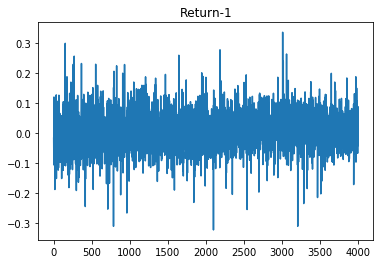

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

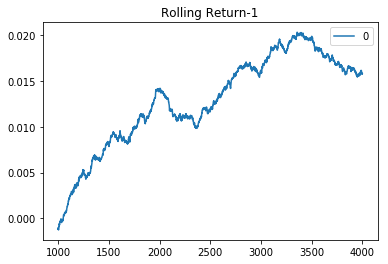

In [67]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

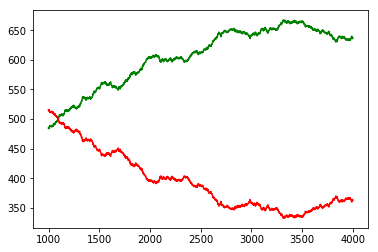

In [68]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

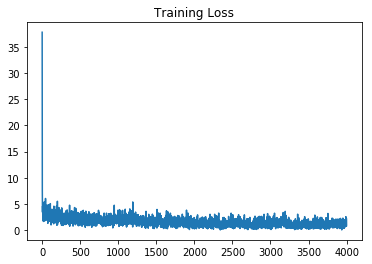

In [69]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

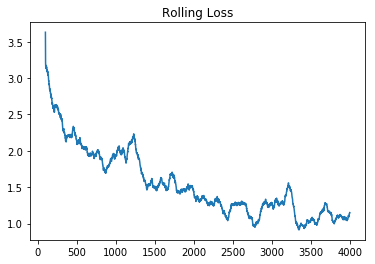

In [70]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

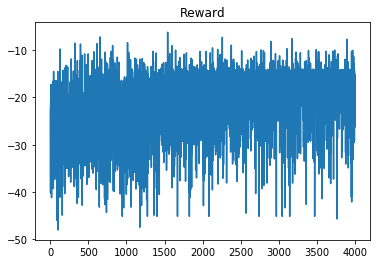

In [71]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

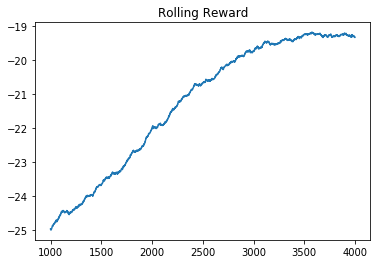

In [72]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

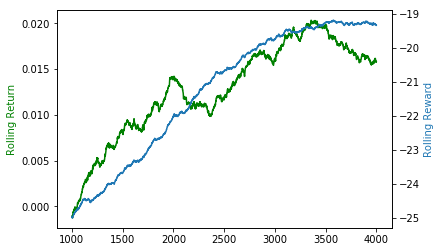

In [73]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

### Testing

Function to run episode with random actions:

In [74]:
def run_random(prices,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    stop_loss = False
    take_profit = False
    day_pos=0
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0 and stop_loss==False and take_profit==False:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        else:
            #trade_log.append(action*(abs(pos)+0))
            trade_log.append(-pos)
            pos = 0 #action #close all existing positions and apply current action          
            
        pos_log.append(pos)
        
        #Store day when last position was openned (for stop_loss & take_profit calc)
        if (pos_log[window_counter]!=0) and (pos_log[window_counter-1]==0):        
            day_pos = window_counter
        
        #Calculate next day's open over all previous days' open (for stop_loss & take_profit trigger)
        if window_counter < trading_window-1:
            open_open_return = prices.iloc[window_counter+1]['Open'] / prices.iloc[:window_counter+1]['Open']
        else:
            open_open_return = prices.iloc[window_counter]['Close'] / prices.iloc[:window_counter+1]['Open']
        #Calculate active return (marked at Open_t+1)
        if pos != 0:
            today_return = [1+trade_log[i]*(open_open_return[i]-1) for i in range(day_pos,window_counter+1)]
            active_return = np.prod(today_return)
        else:
            active_return = 1   
        
        
        #Check stop_loss and take_profit
        stop_loss = True if active_return < stop_loss_thres else False
        take_profit = True if active_return > take_prof_thres else False
        
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

Function to run episode with trained model and random model:

In [75]:
def run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data,verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    stop_loss_log = info_log['stop_loss_log']
    
    
    if verbose == 1 : #and info_log['total_return'] <= 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        
        start_date = pd.to_datetime(plt_df.index[0]).strftime('%Y-%m-%d')
        end_date = pd.to_datetime(plt_df.index[-1]).strftime('%Y-%m-%d')
        
        #Plot some days before the start of the episode to see recent trends             
        start_index = np.where((raw_data.Open==plt_df.iloc[0].Open)&(raw_data.Close==plt_df.iloc[0].Close)&(raw_data.Volume==plt_df.iloc[0].Volume))[0][0]
        end_index = np.where((raw_data.Open==plt_df.iloc[-1].Open)&(raw_data.Close==plt_df.iloc[-1].Close)&(raw_data.Volume==plt_df.iloc[-1].Volume))[0][0]
        
        plt.plot(raw_data.iloc[max(start_index-10,0):start_index+1].index,raw_data.iloc[max(start_index-10,0):start_index+1].Open,'--',color='gray')
        plt.plot(raw_data.iloc[start_index:end_index+1].index,raw_data.iloc[start_index:end_index+1].Open,color='black')
        
        plt.ylim(min(raw_data.iloc[max(start_index-10,0):end_index].Open)*0.95, max(raw_data.iloc[max(start_index-10,0):end_index].Open)*1.05)
        plt.ylabel('Open Price')
        
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Open,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Sells
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Open,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if stop_loss_log[i]:
                    txt = str(txt) + ' (S)'
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Open[i]+0.02*plt_df.Open[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Open[i]-0.02*plt_df.Open[i]))

        plt.show()
    return info_log['total_return'], random_return

Set up environment for testing:

In [76]:
import gym
import gym_market
import numpy as np
import imp

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_test, 
                  'raw_data':raw_data_test}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


Run tests:

Return: 0.960
Random return: 0.937


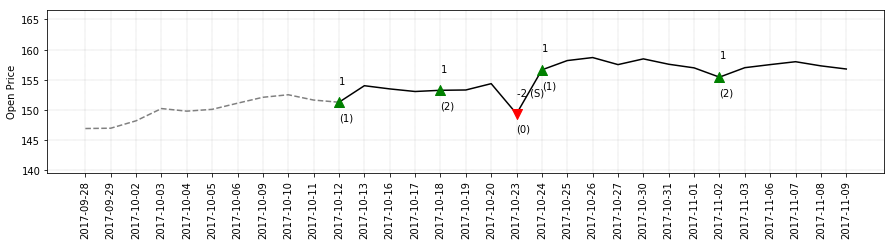

Return: 1.079
Random return: 1.038


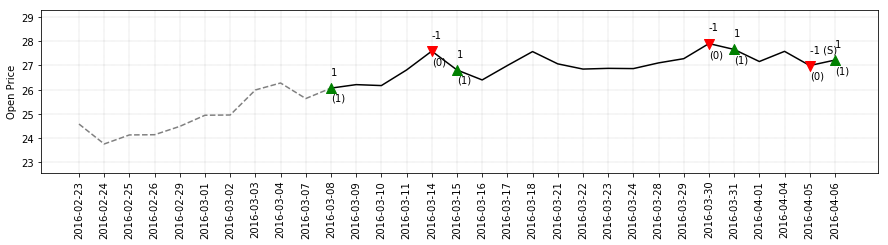

Return: 0.836
Random return: 0.949


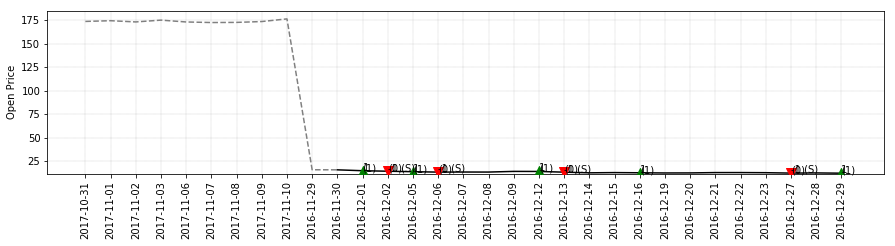

Return: 0.983
Random return: 0.973


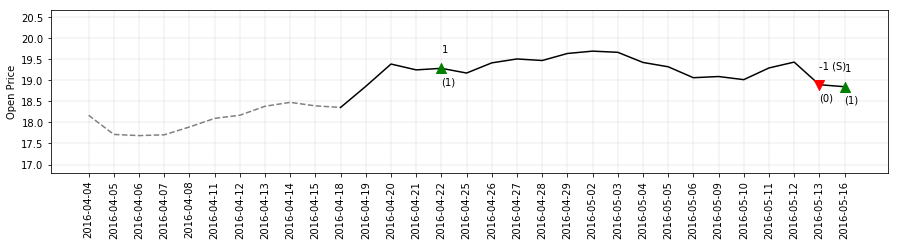

Return: 0.988
Random return: 1.062


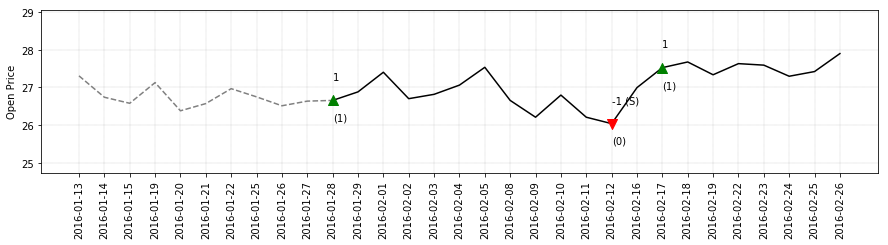

Return: 0.907
Random return: 0.986


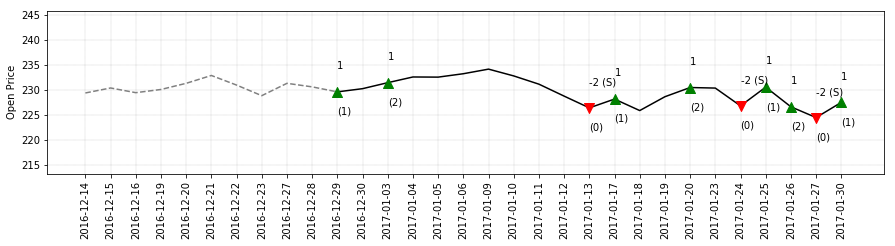

Return: 0.984
Random return: 0.905


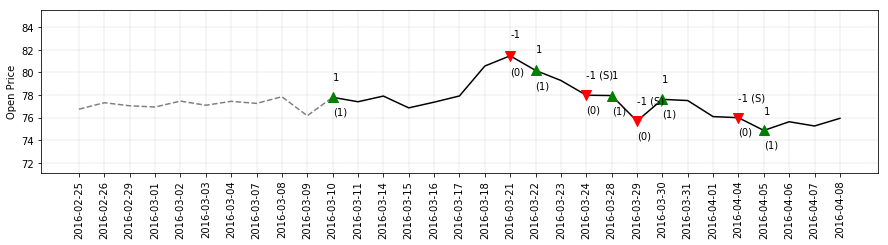

Return: 1.069
Random return: 1.082


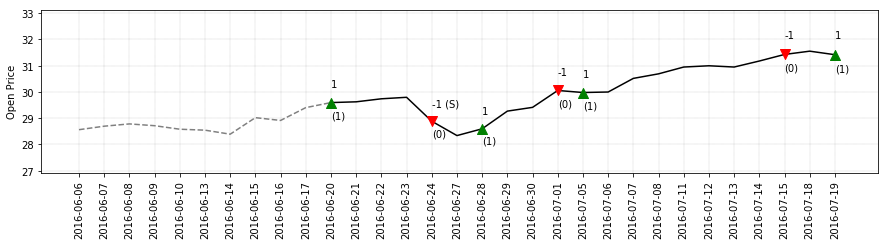

Return: 1.090
Random return: 1.003


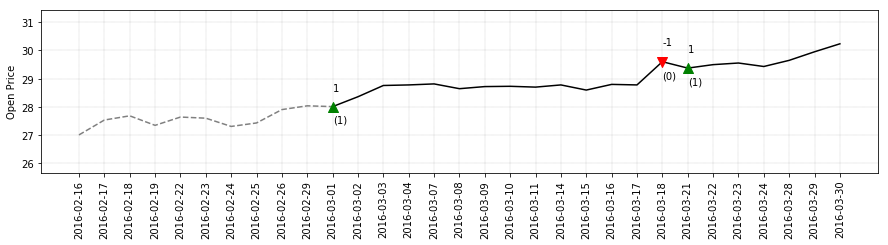

Return: 1.062
Random return: 1.045


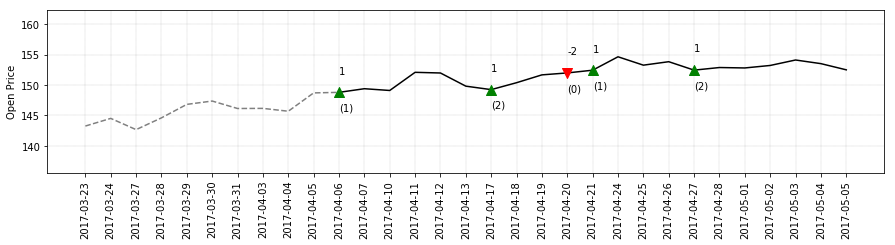

Return: 1.051
Random return: 0.999


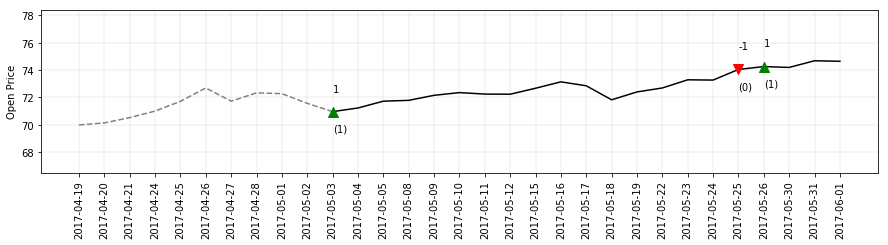

Return: 0.981
Random return: 0.987


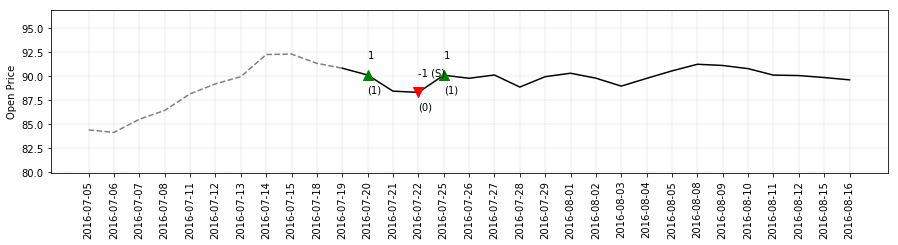

Return: 0.997
Random return: 1.043


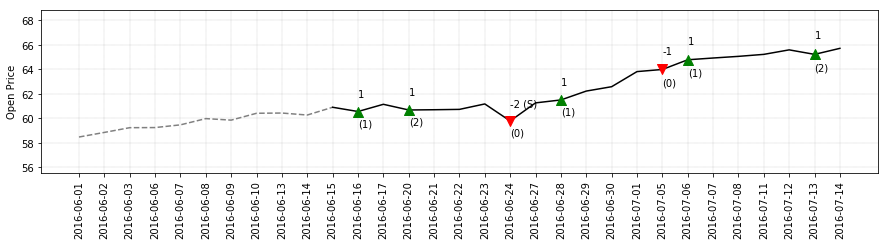

Return: 1.014
Random return: 1.002


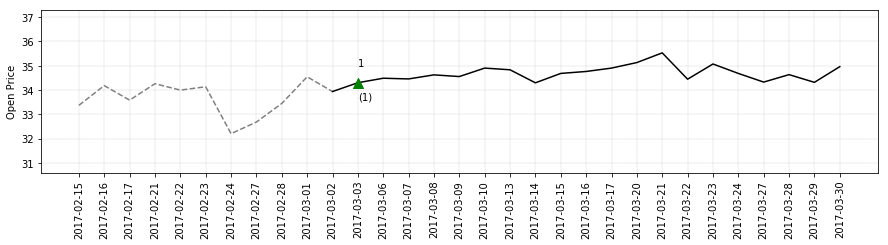

Return: 1.007
Random return: 1.022


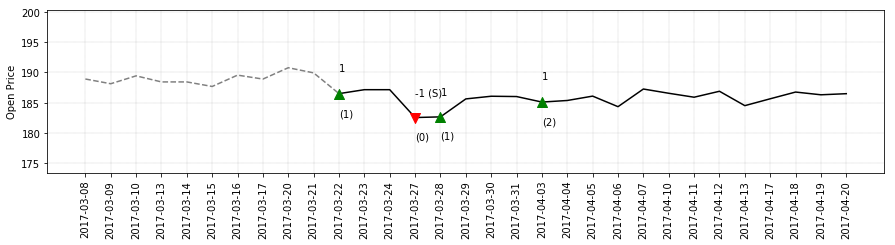

Return: 1.019
Random return: 1.009


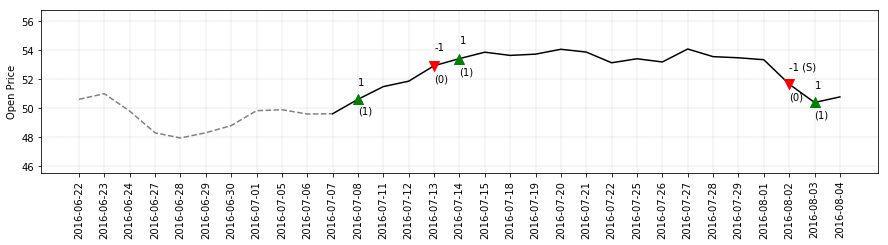

Return: 0.900
Random return: 1.049


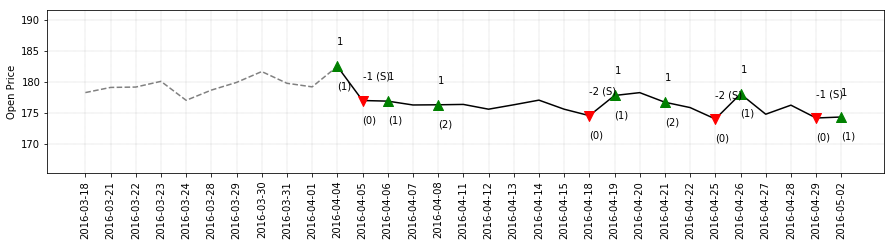

Return: 1.041
Random return: 1.071


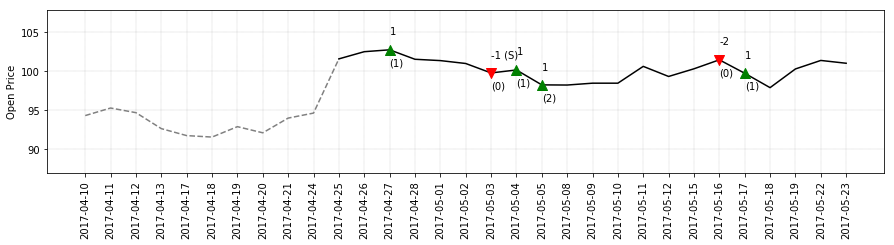

Return: 1.018
Random return: 0.969


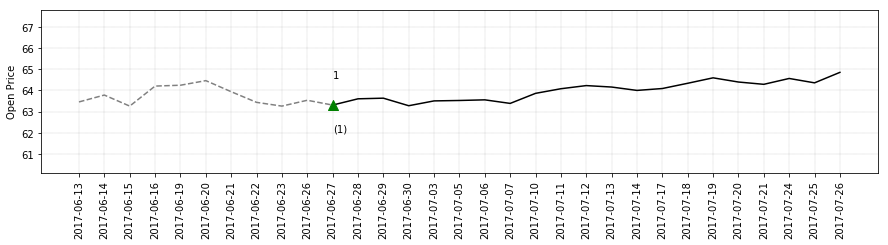

Return: 1.077
Random return: 0.932


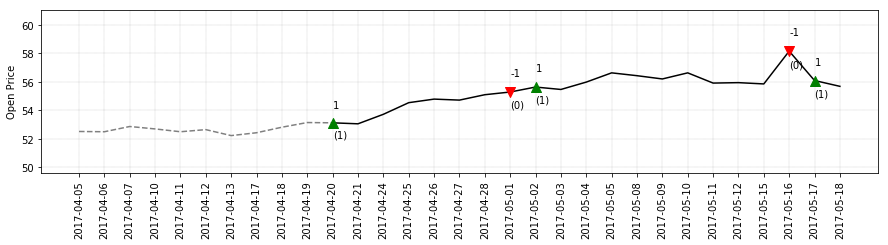

Return: 1.071
Random return: 0.985


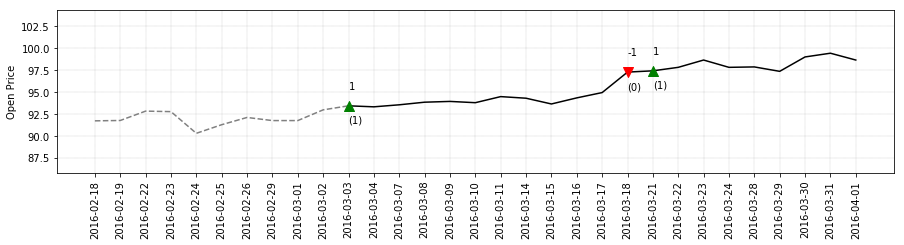

Return: 0.859
Random return: 1.001


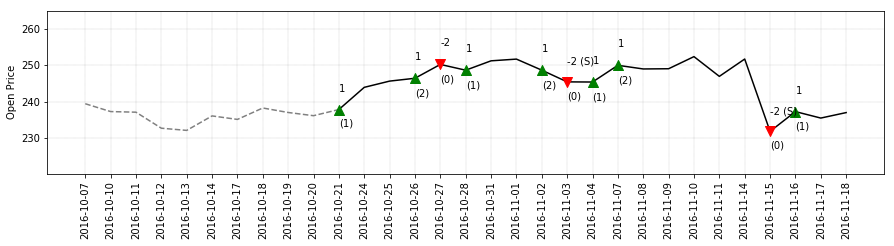

Return: 1.048
Random return: 1.038


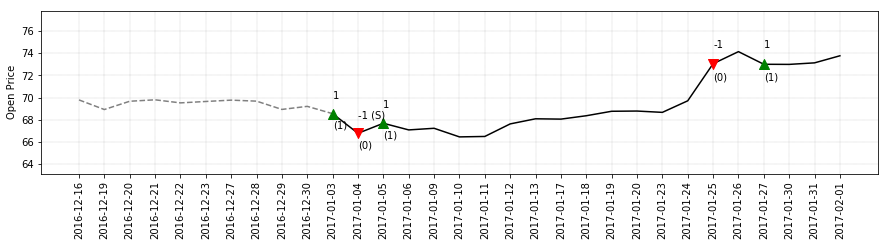

Return: 0.986
Random return: 1.000


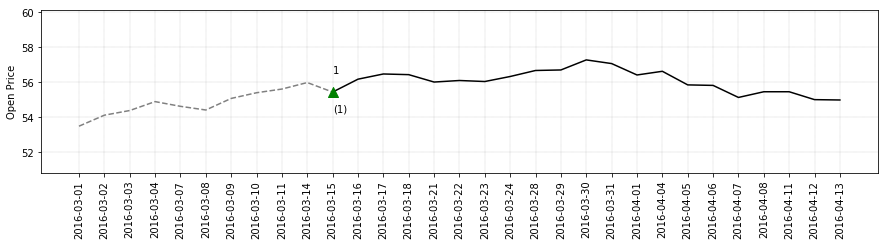

Return: 0.944
Random return: 0.931


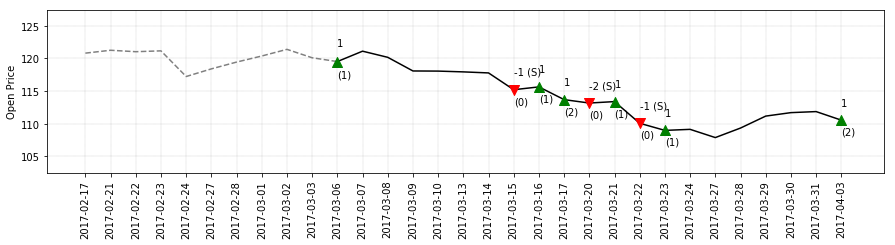

Return: 1.054
Random return: 1.013


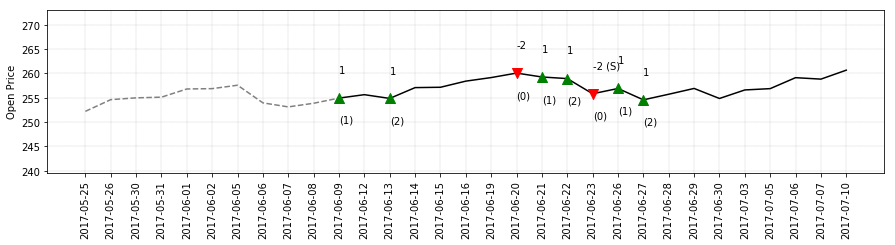

Return: 0.983
Random return: 0.982


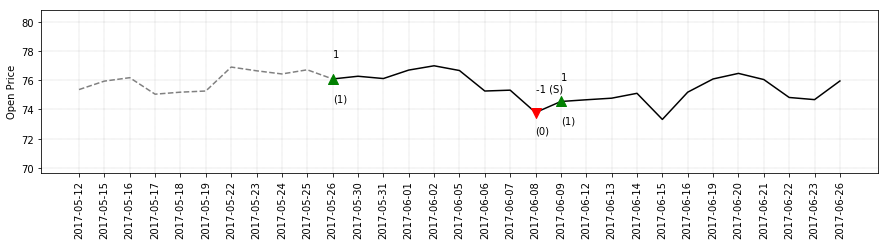

Return: 1.033
Random return: 1.072


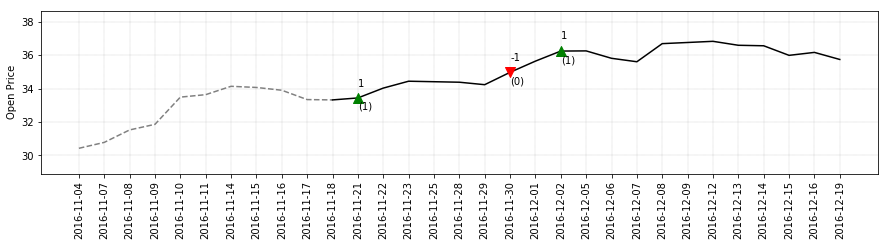

Return: 1.024
Random return: 0.985


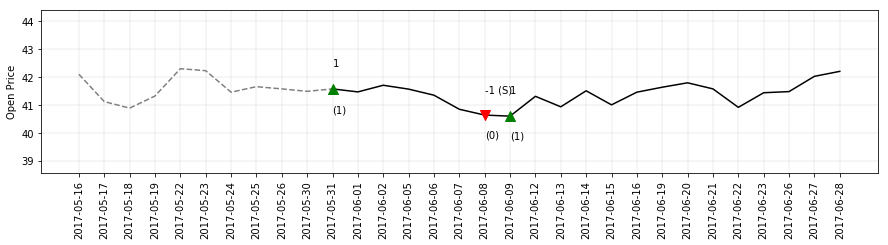

Return: 1.063
Random return: 0.967


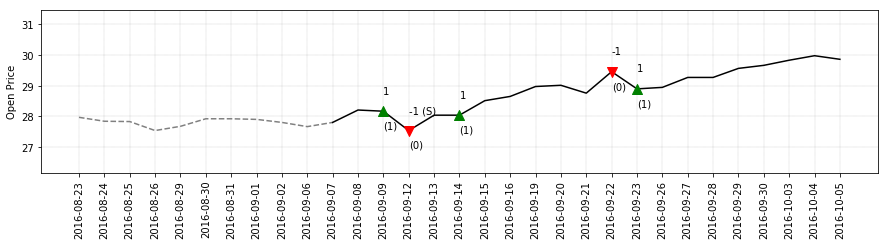

Return: 1.050
Random return: 1.080


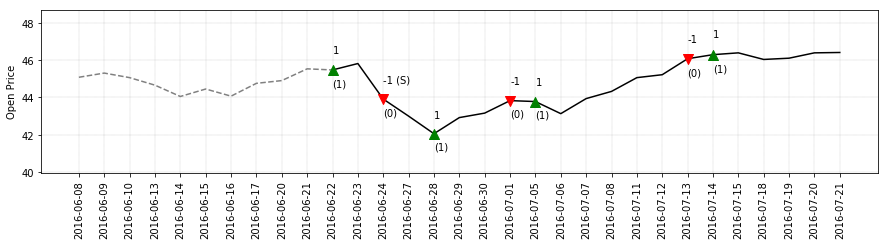

Return: 1.031
Random return: 0.904


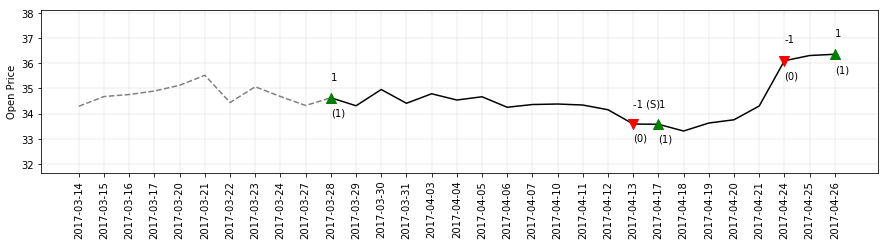

Return: 1.080
Random return: 1.029


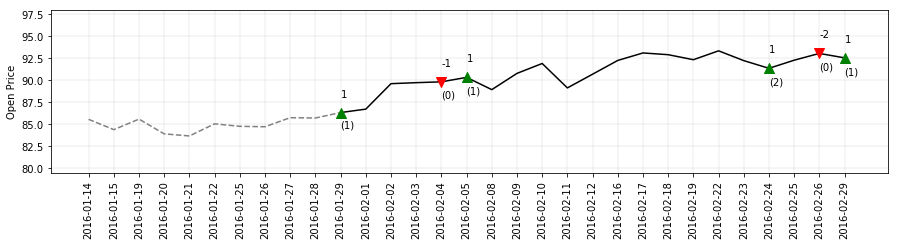

Return: 1.043
Random return: 1.057


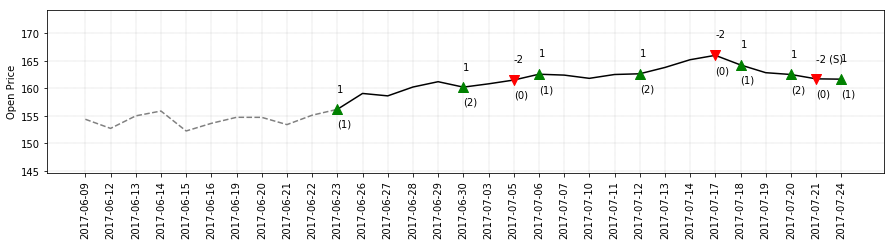

Return: 0.989
Random return: 1.002


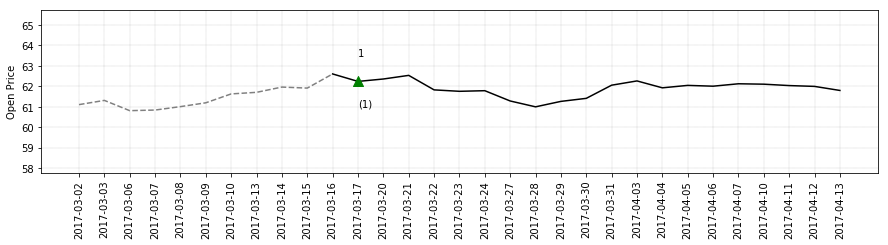

Return: 1.114
Random return: 0.880


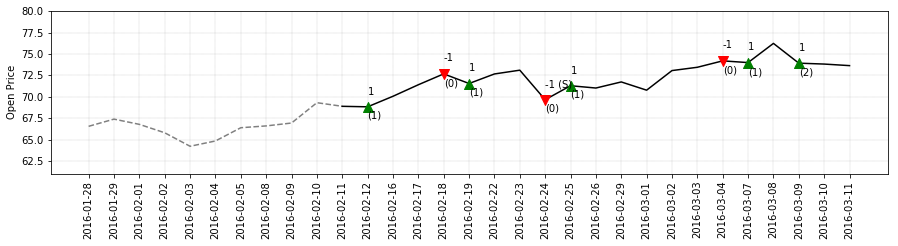

Return: 1.037
Random return: 0.988


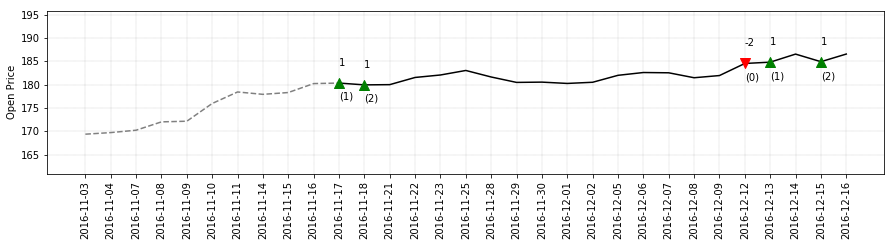

Return: 1.012
Random return: 0.977


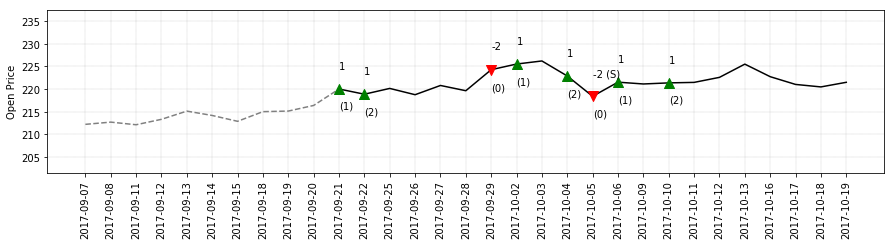

Return: 0.966
Random return: 1.018


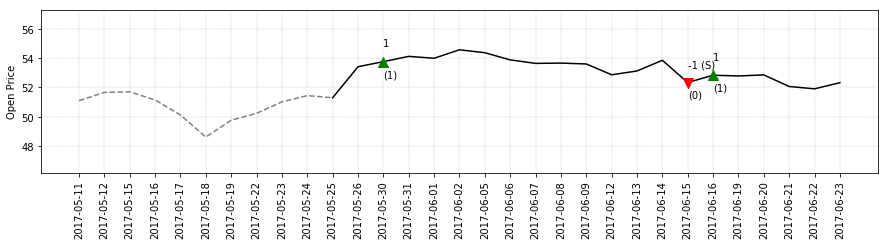

Return: 0.938
Random return: 0.988


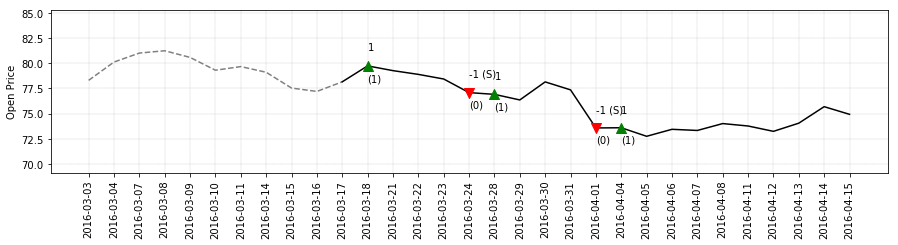

Return: 1.070
Random return: 1.044


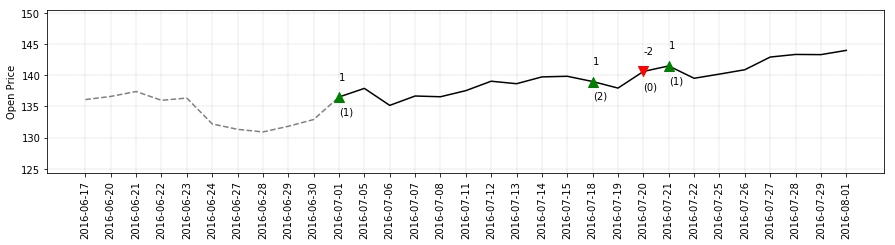

Return: 0.968
Random return: 0.940


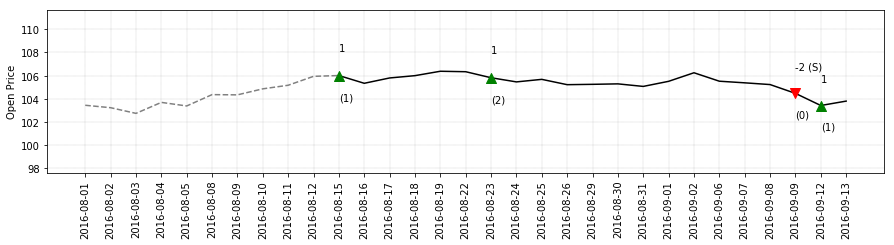

Return: 1.009
Random return: 0.984


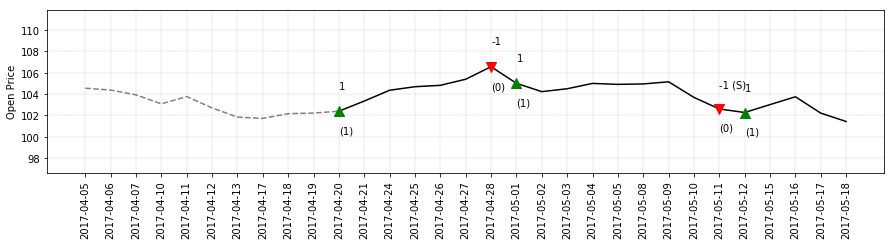

Return: 0.999
Random return: 0.961


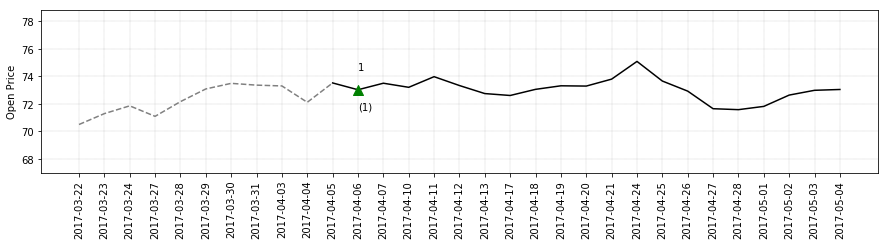

Return: 0.914
Random return: 0.926


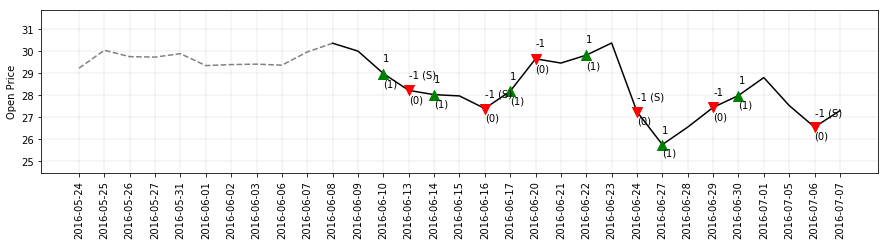

Return: 0.934
Random return: 0.985


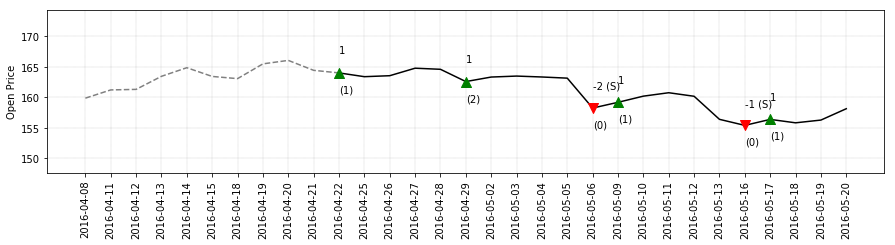

Return: 1.006
Random return: 0.939


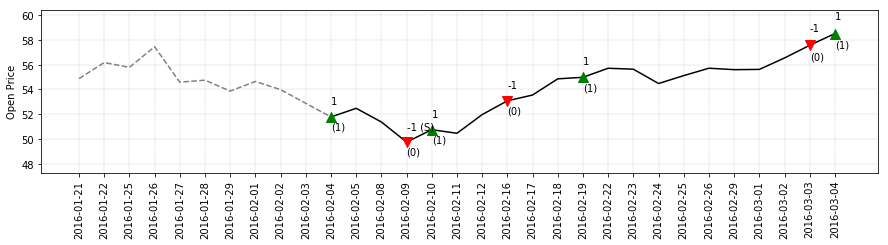

Return: 1.015
Random return: 1.027


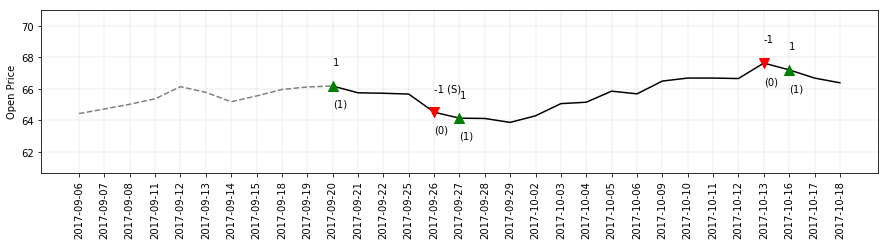

Return: 1.041
Random return: 1.030


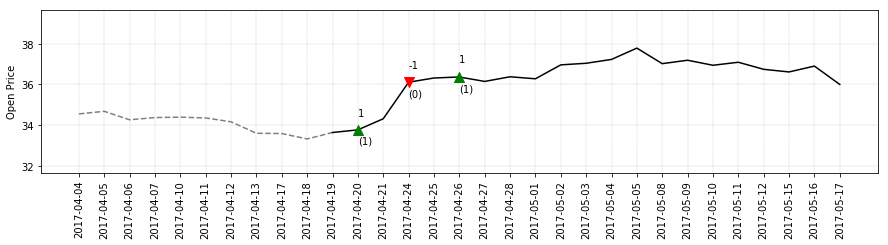

Return: 1.122
Random return: 1.013


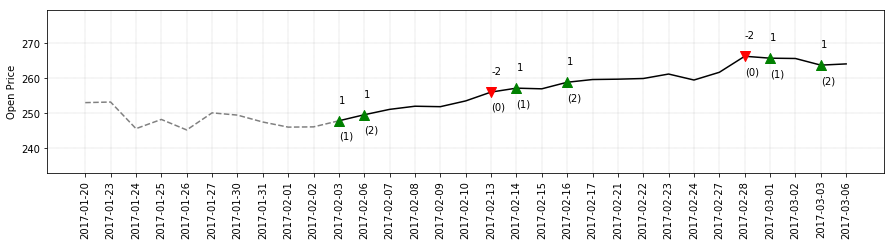

Return: 1.031
Random return: 0.921


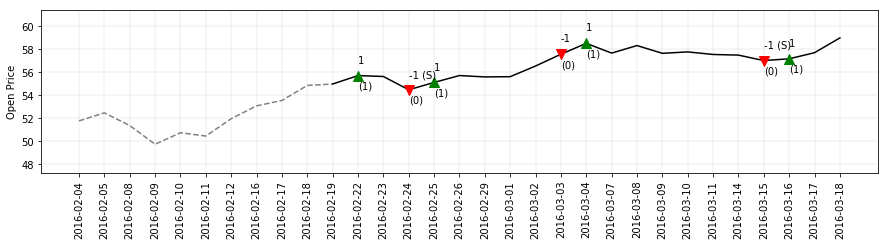

Return: 1.068
Random return: 0.943


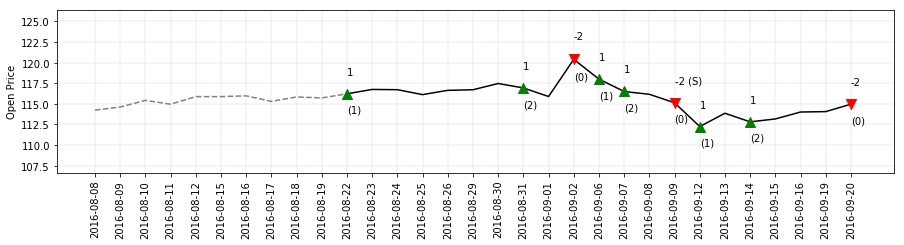

Return: 1.022
Random return: 0.985


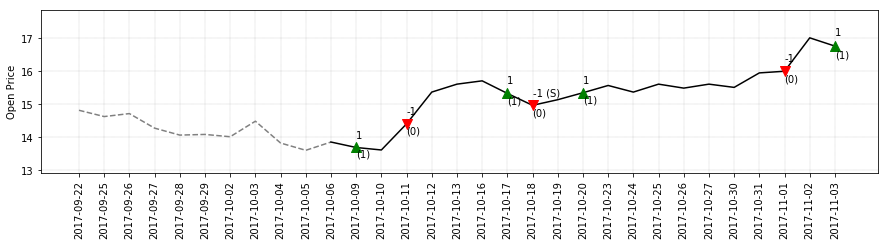

Return: 1.019
Random return: 0.885


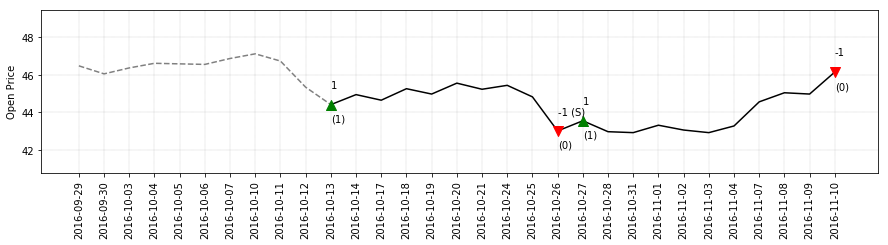

Return: 1.038
Random return: 0.982


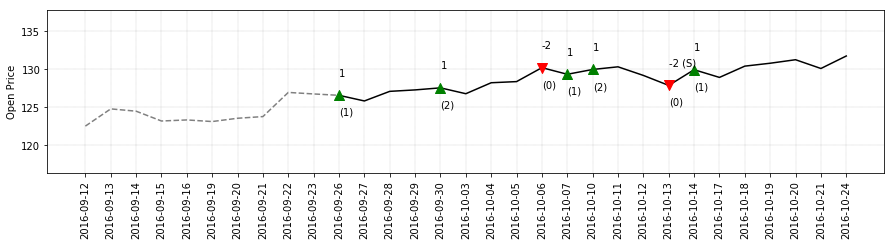

Return: 1.069
Random return: 0.943


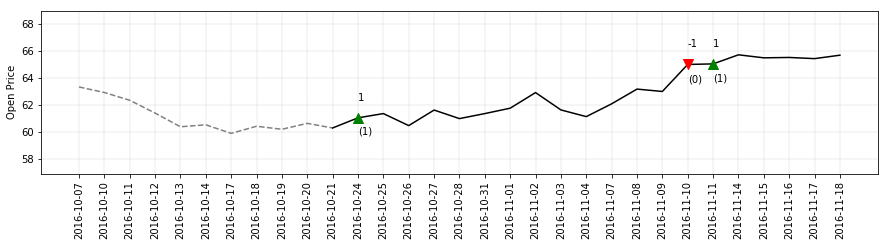

Return: 1.020
Random return: 0.915


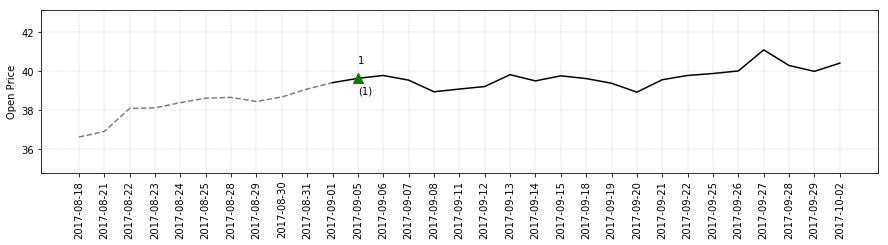

Return: 1.009
Random return: 0.999


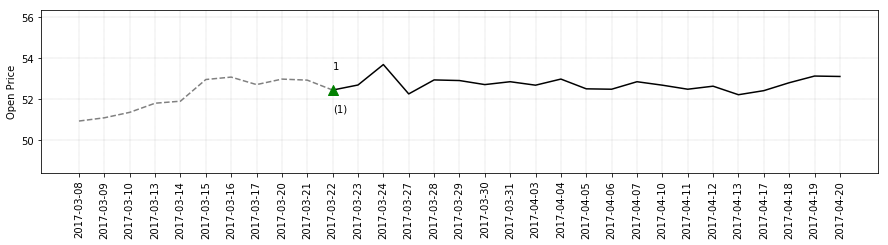

Return: 1.005
Random return: 1.016


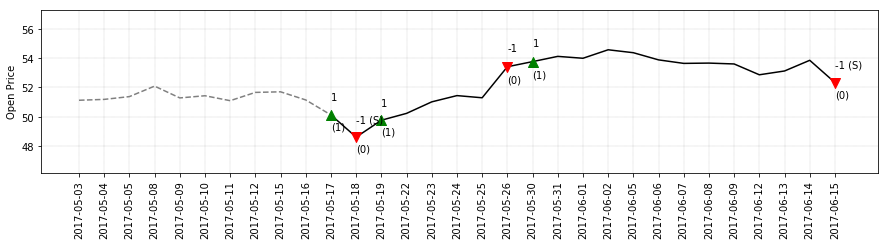

Return: 1.011
Random return: 0.890


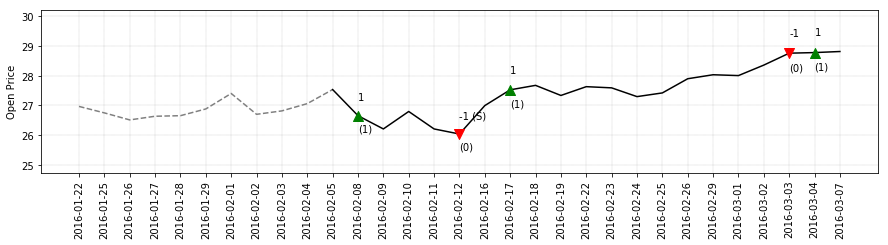

Return: 0.995
Random return: 0.940


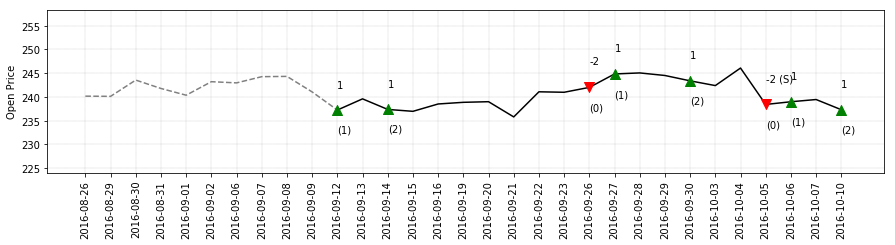

Return: 1.064
Random return: 1.022


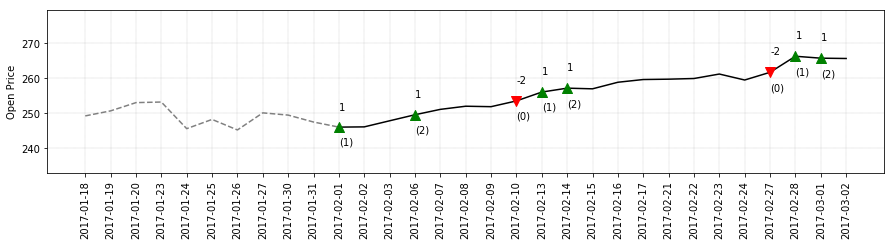

Return: 0.934
Random return: 0.954


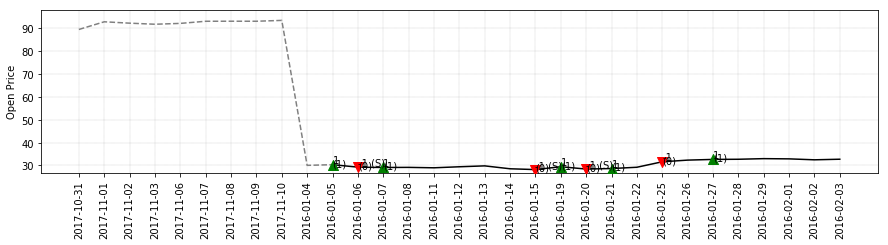

Return: 0.973
Random return: 0.997


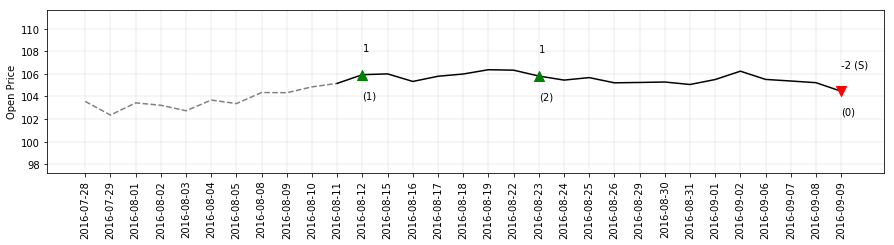

Return: 1.072
Random return: 1.014


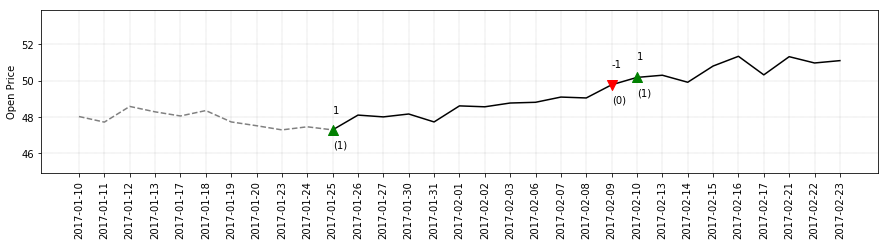

Return: 1.057
Random return: 0.954


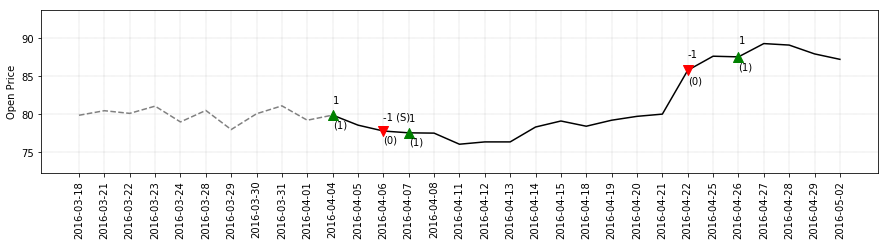

Return: 0.963
Random return: 1.049


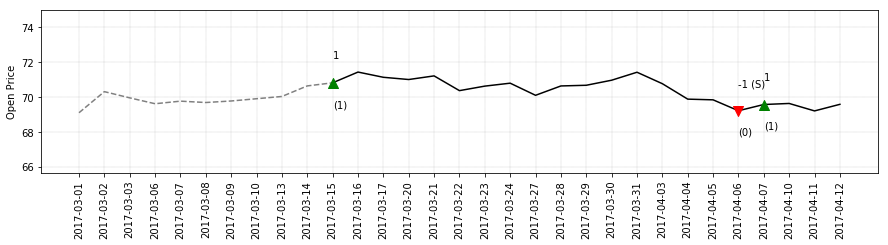

Return: 1.082
Random return: 1.181


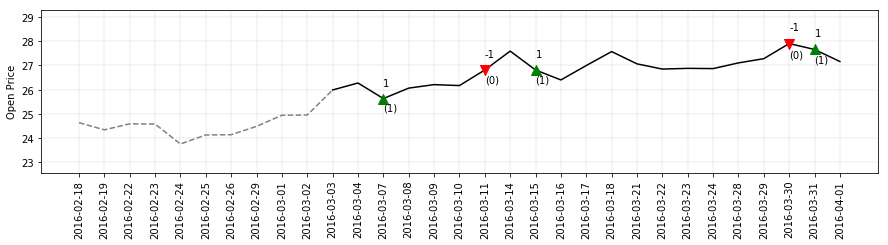

Return: 0.943
Random return: 0.993


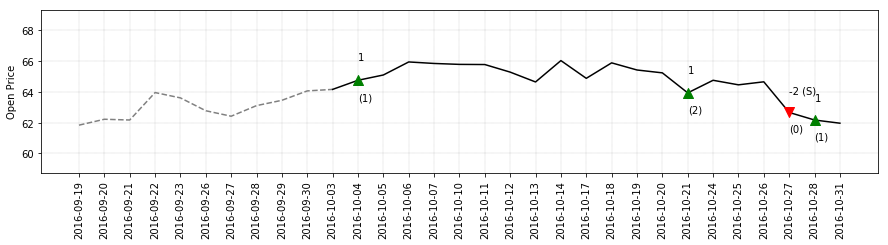

Return: 0.992
Random return: 1.037


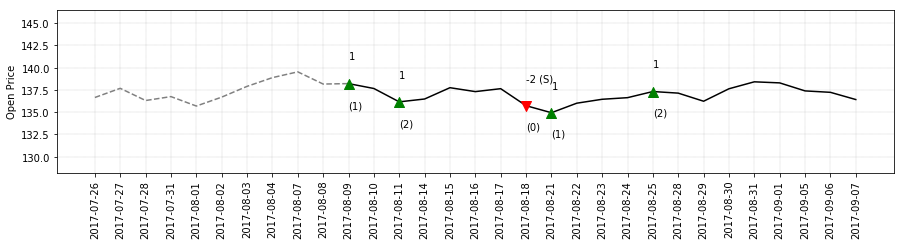

Return: 0.900
Random return: 0.984


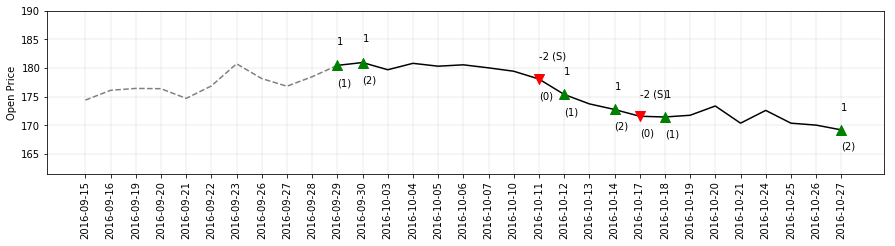

Return: 0.947
Random return: 1.129


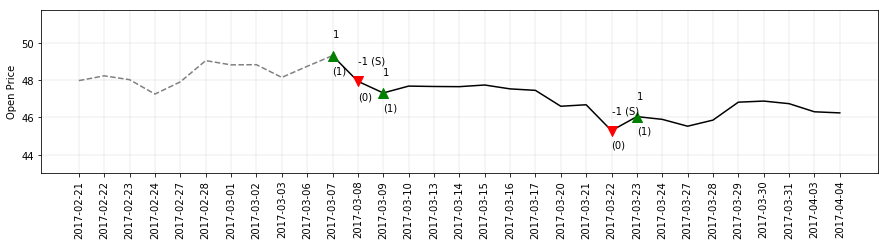

Return: 0.984
Random return: 1.079


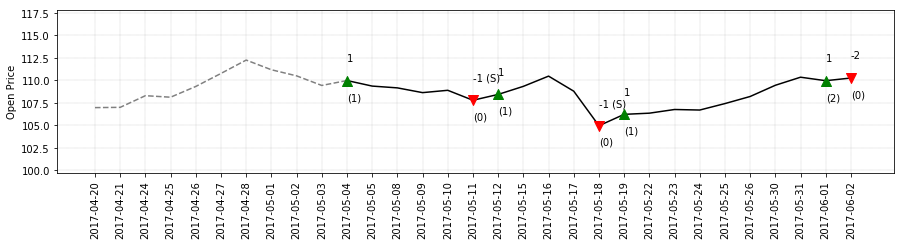

Return: 0.984
Random return: 1.026


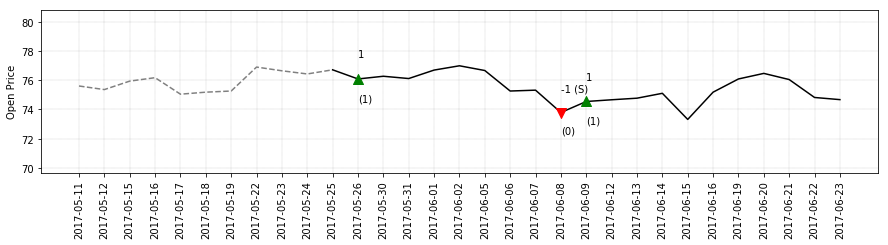

Return: 0.855
Random return: 0.910


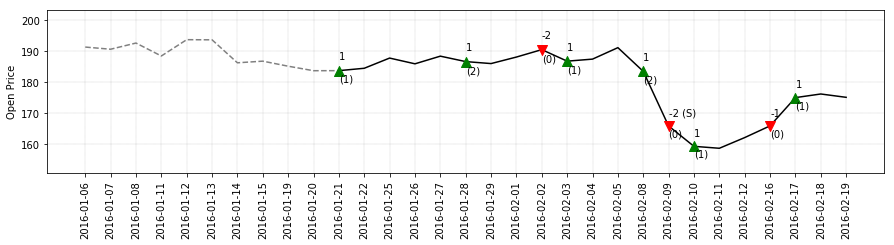

Return: 0.986
Random return: 1.008


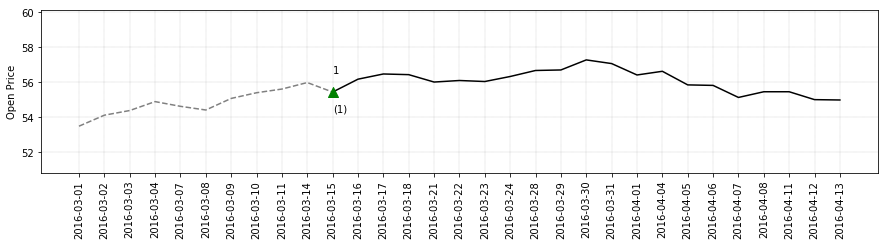

Return: 0.965
Random return: 1.066


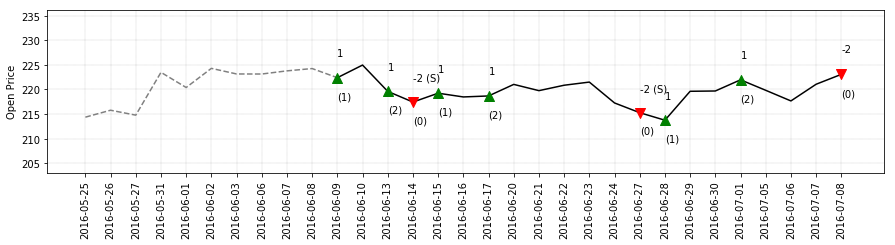

Return: 1.129
Random return: 0.837


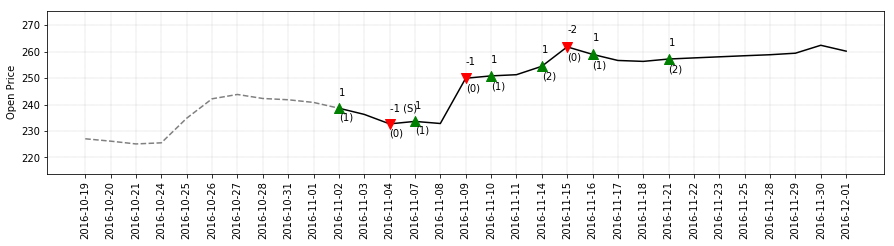

Return: 1.018
Random return: 0.837


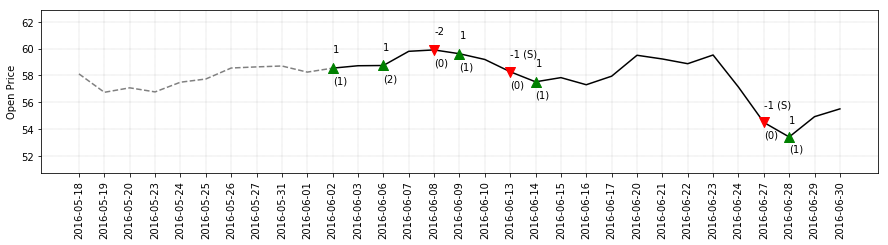

Return: 1.012
Random return: 0.992


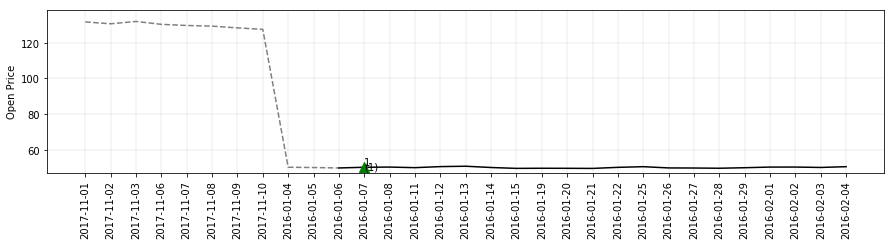

Return: 0.949
Random return: 0.925


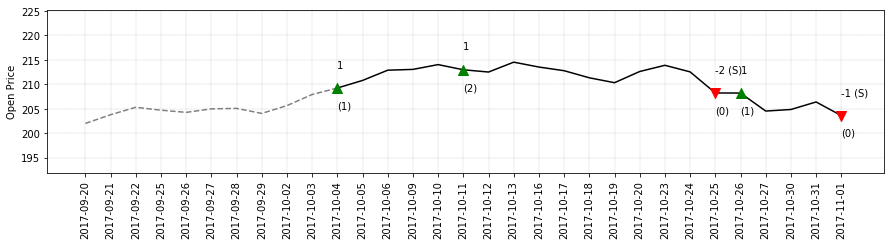

Return: 0.993
Random return: 0.940


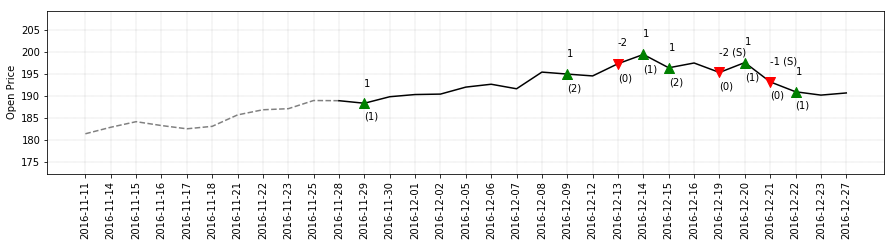

Return: 0.958
Random return: 1.100


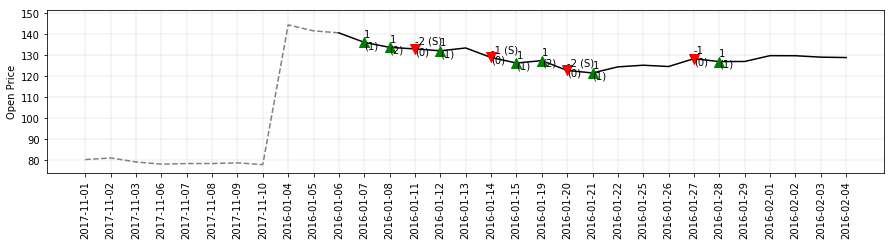

Return: 1.015
Random return: 0.968


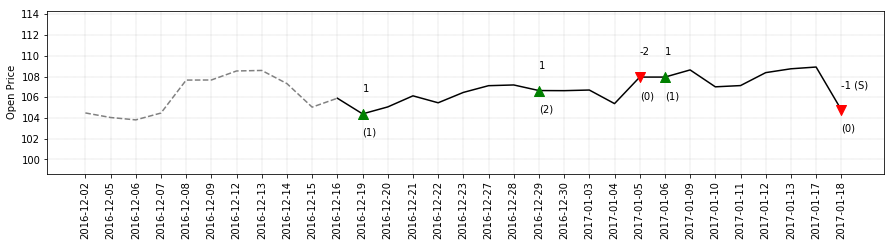

Return: 1.011
Random return: 0.927


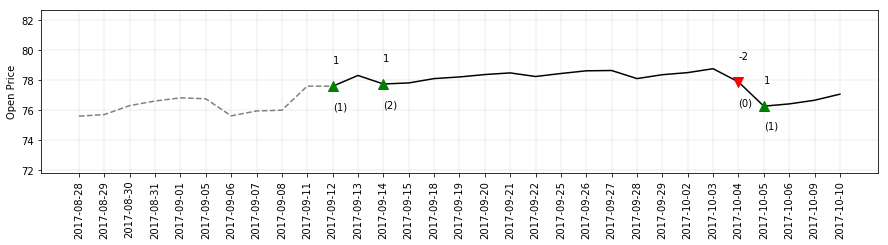

Return: 1.028
Random return: 0.947


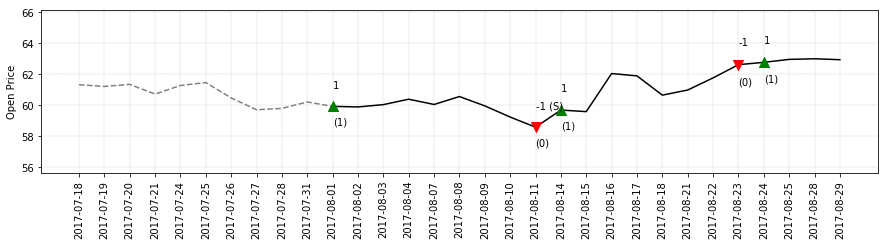

Return: 0.994
Random return: 0.998


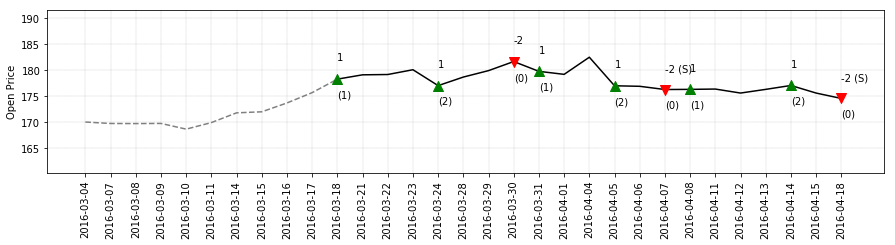

Return: 1.199
Random return: 1.036


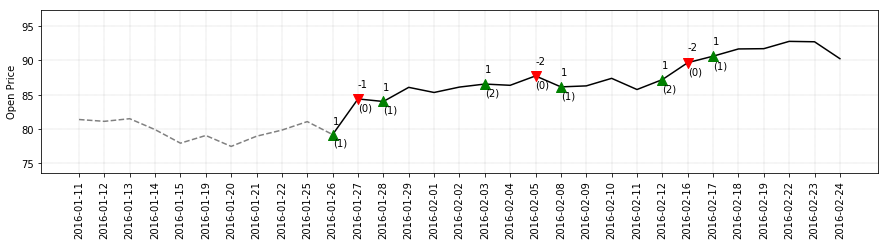

Return: 1.000
Random return: 1.046


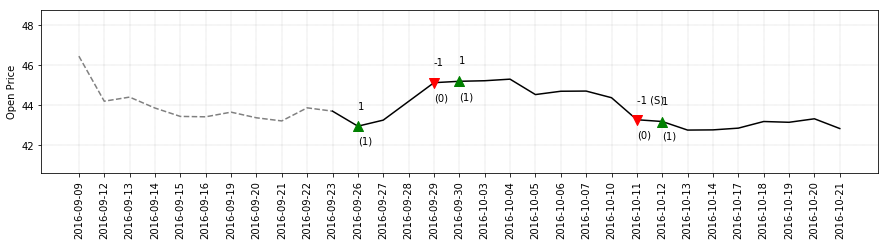

Return: 1.028
Random return: 0.951


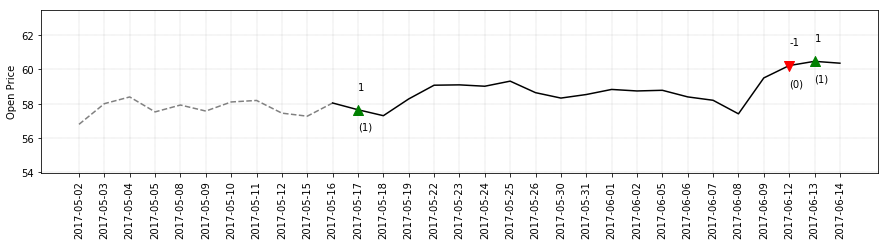

Return: 1.044
Random return: 1.014


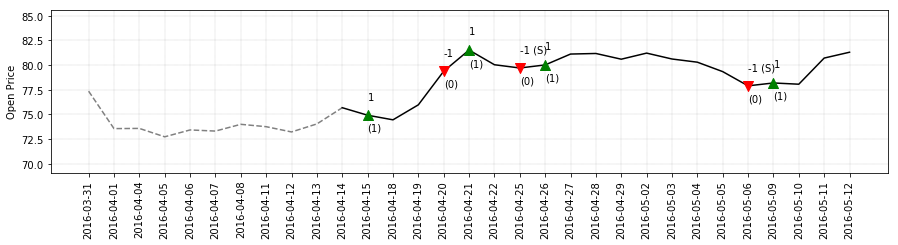

Return: 1.061
Random return: 1.019


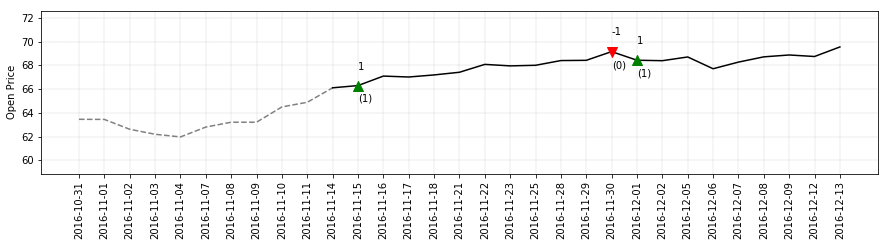

Return: 0.971
Random return: 0.995


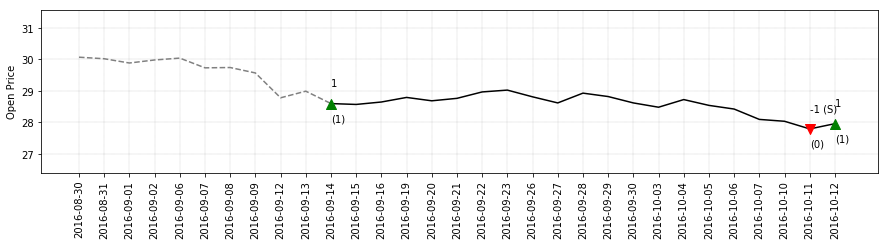

Return: 1.051
Random return: 1.034


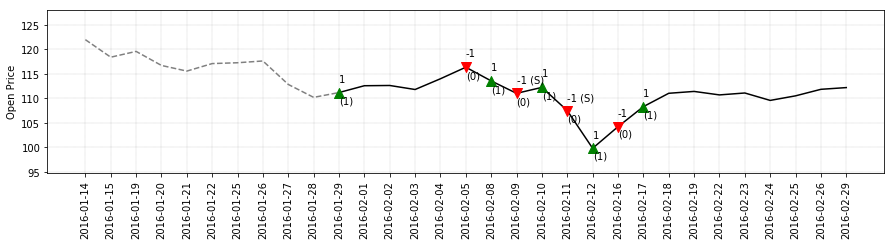

Return: 0.880
Random return: 1.035


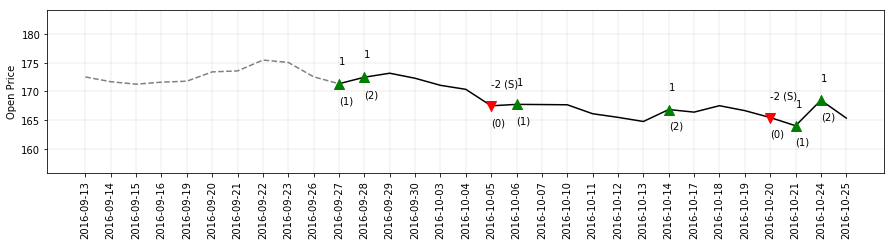

Return: 0.977
Random return: 0.958


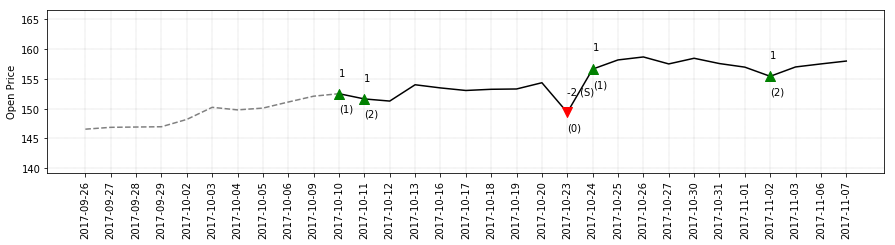

Return: 1.035
Random return: 1.113


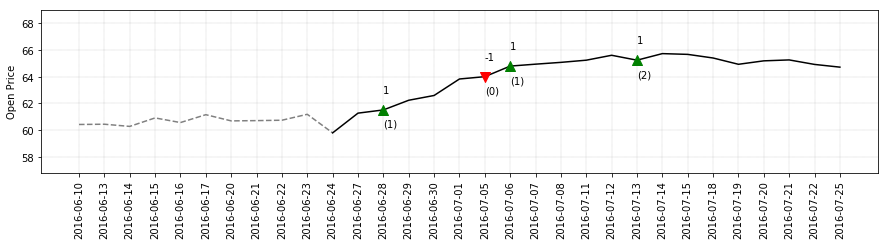

Return: 0.988
Random return: 0.985


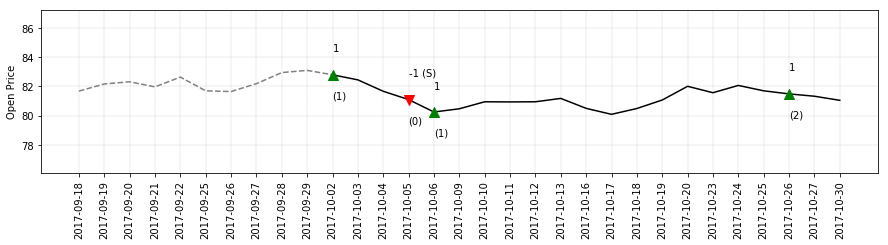

Return: 1.058
Random return: 1.027


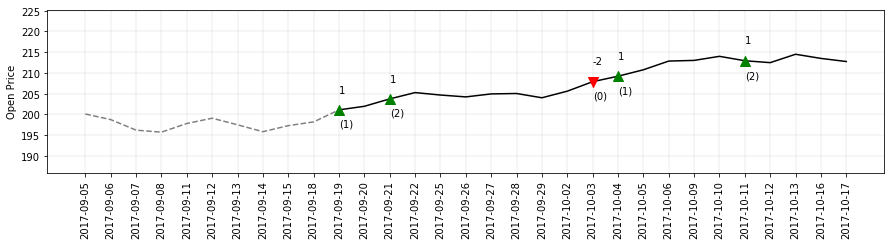

Return: 1.102
Random return: 1.006


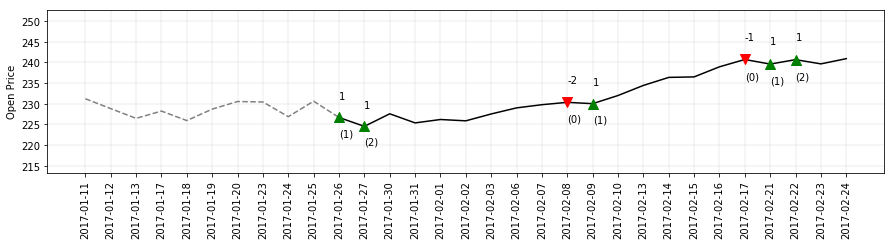

Return: 0.994
Random return: 1.042


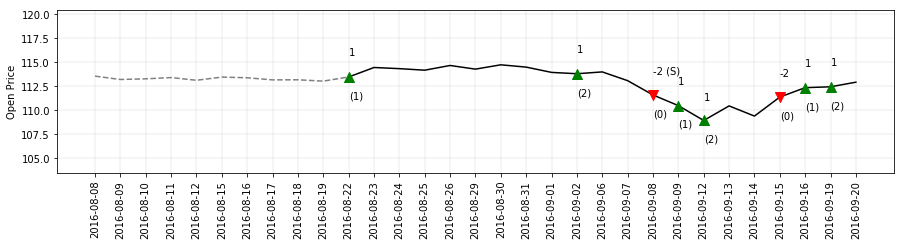

Return: 0.972
Random return: 0.964


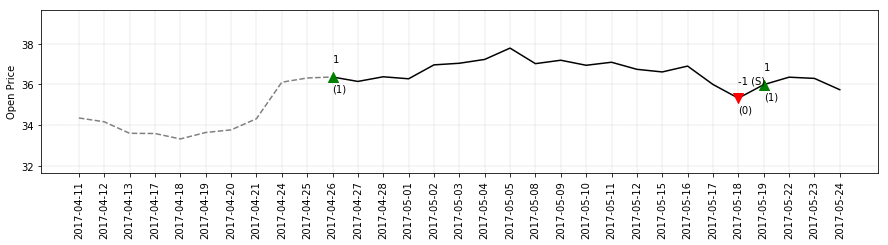

Return: 1.044
Random return: 1.035


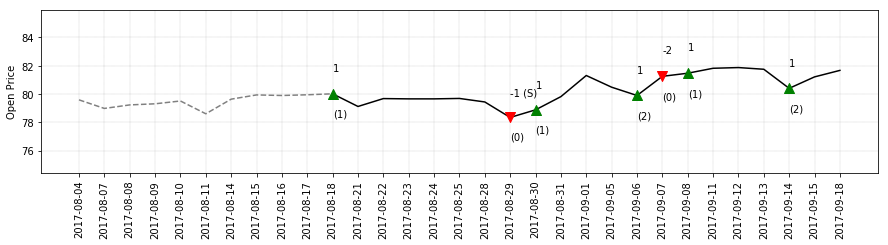

Return: 1.100
Random return: 1.010


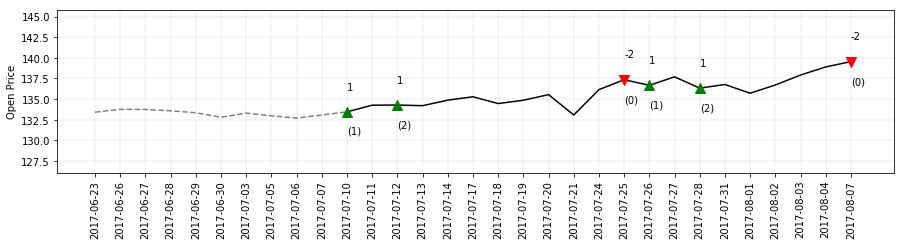

Return: 1.061
Random return: 1.035


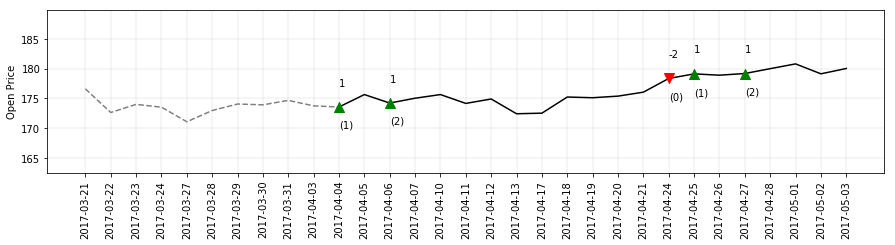

Return: 0.960
Random return: 1.015


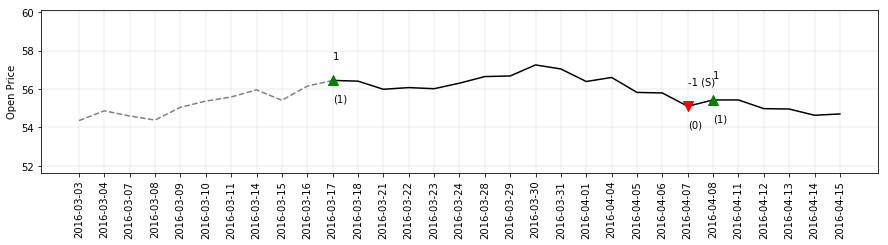

Return: 0.929
Random return: 0.936


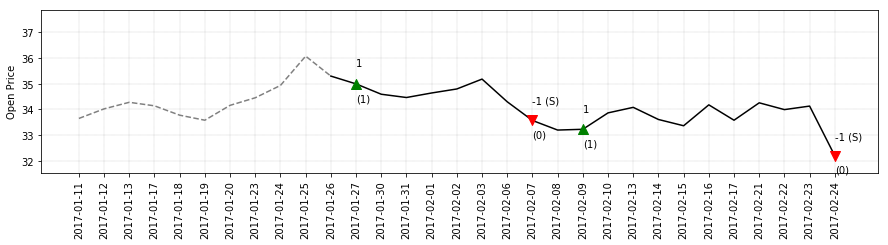

Return: 0.986
Random return: 0.935


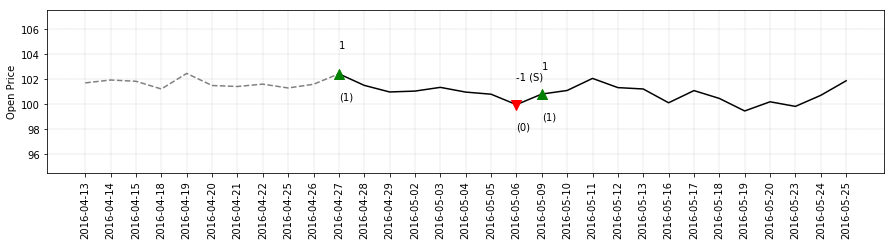

Return: 1.021
Random return: 0.956


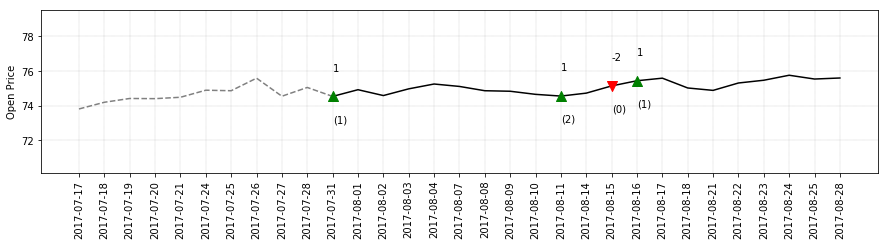

Return: 1.051
Random return: 0.965


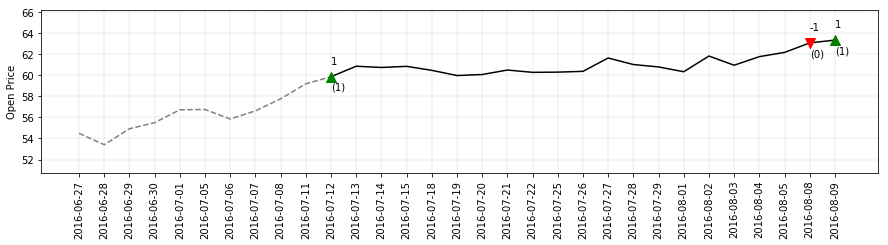

Return: 1.042
Random return: 1.038


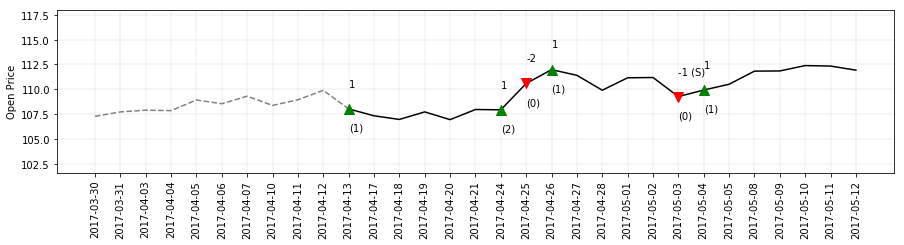

Return: 1.020
Random return: 0.890


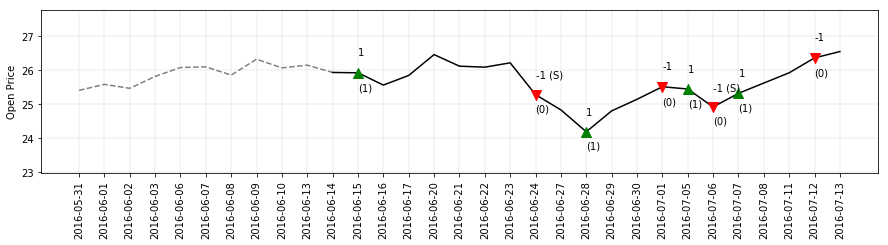

Return: 0.962
Random return: 1.019


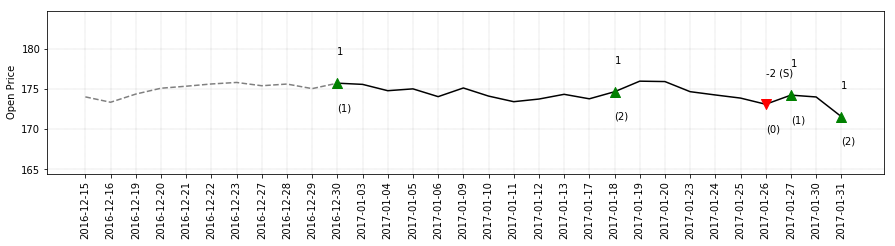

Return: 0.946
Random return: 1.051


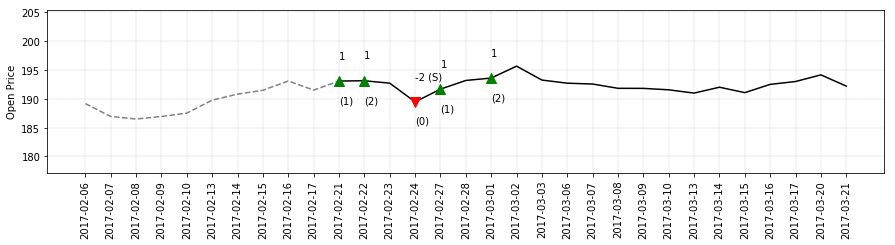

Return: 0.966
Random return: 0.997


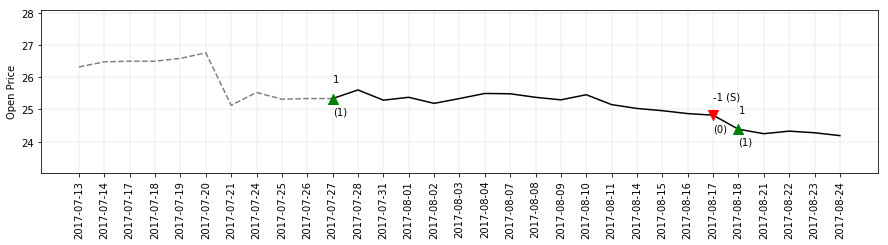

Return: 1.111
Random return: 0.750


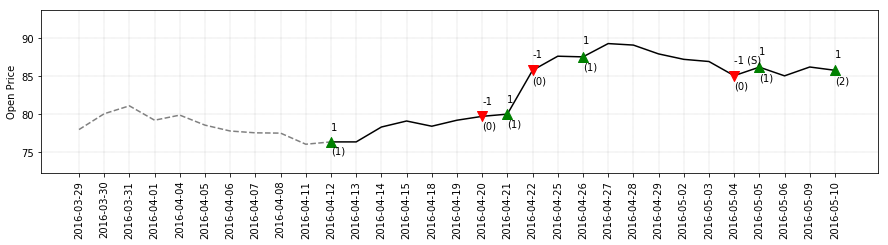

Return: 1.051
Random return: 0.848


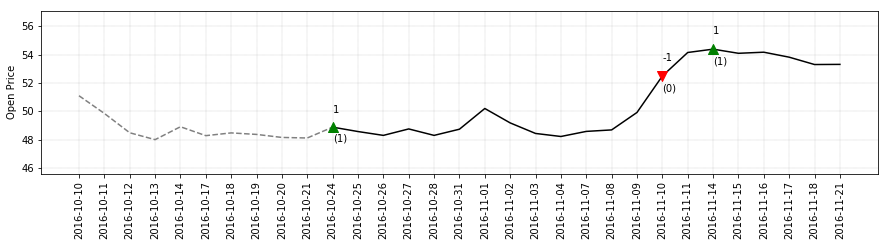

Return: 0.984
Random return: 1.022


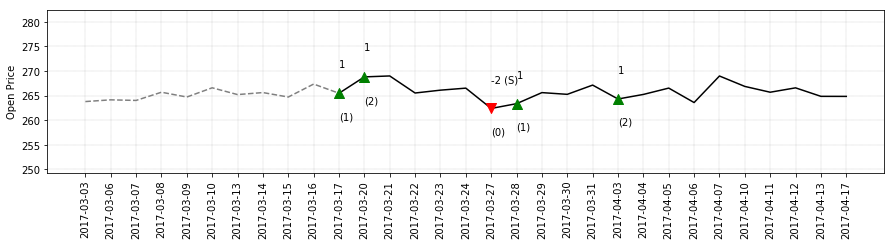

Return: 0.907
Random return: 0.918


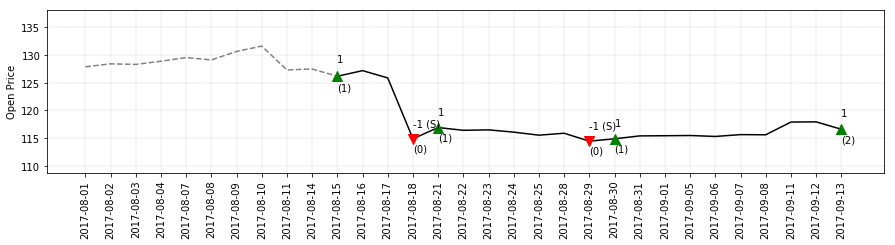

Return: 0.976
Random return: 1.127


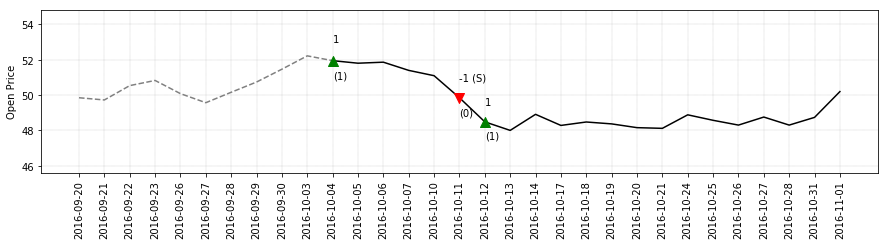

Return: 1.075
Random return: 0.977


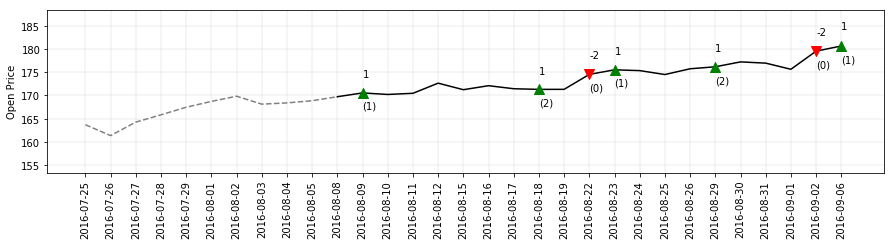

Return: 1.108
Random return: 0.904


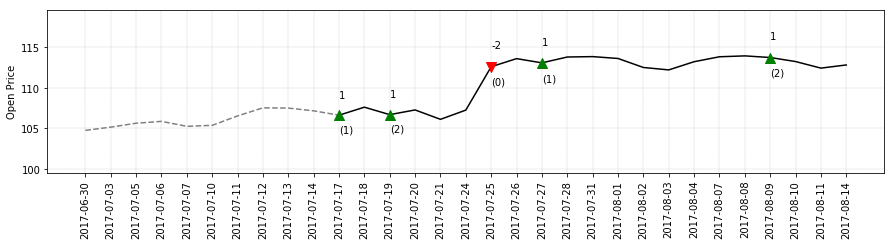

Return: 1.023
Random return: 0.988


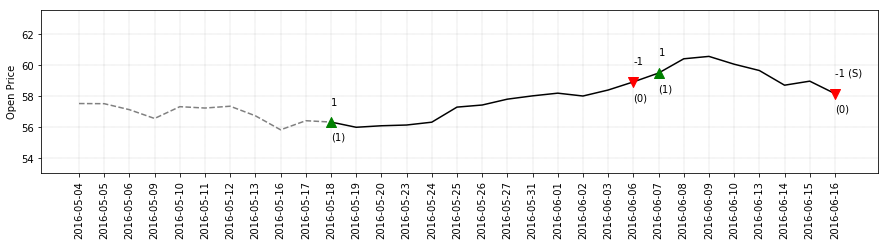

Return: 1.074
Random return: 0.962


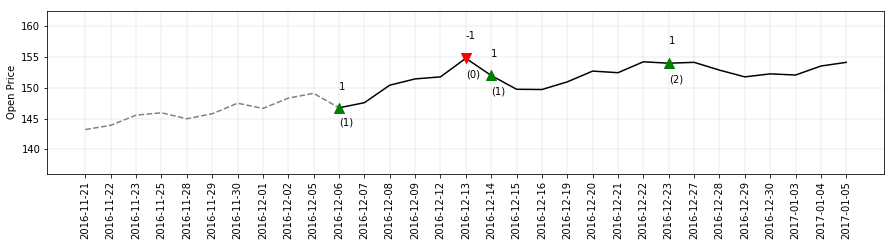

Return: 0.983
Random return: 1.104


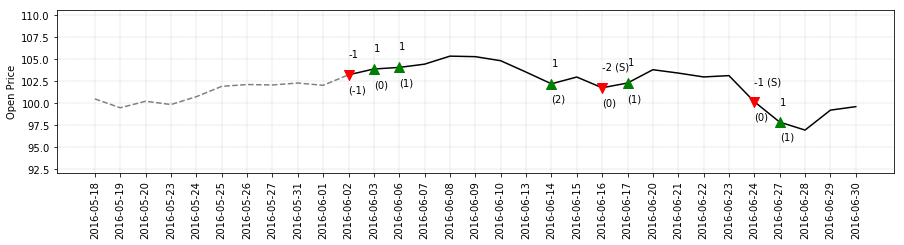

Return: 1.021
Random return: 1.025


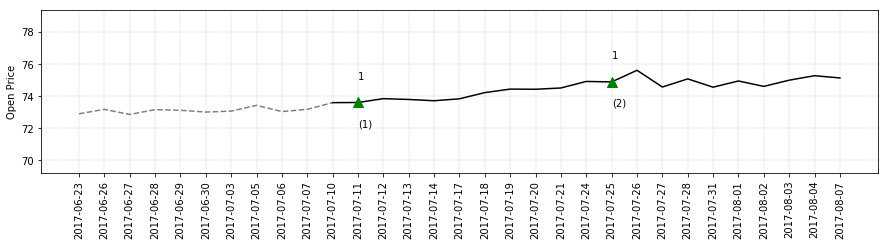

Return: 0.964
Random return: 0.976


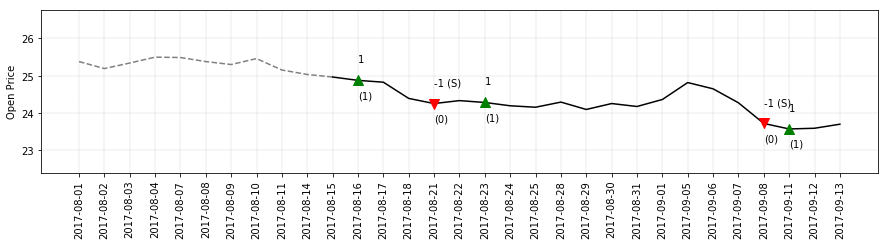

Return: 1.011
Random return: 1.000


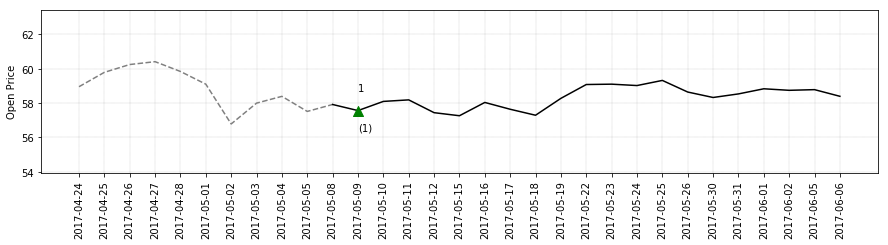

Return: 1.054
Random return: 0.958


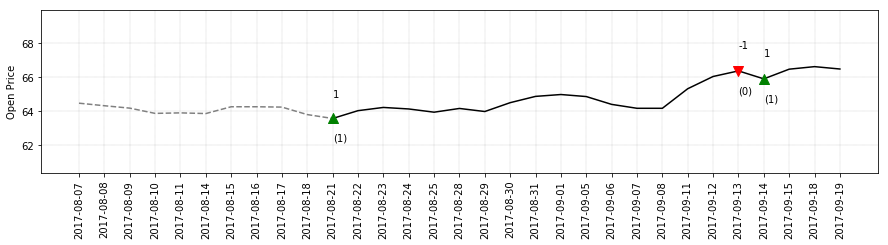

Return: 0.998
Random return: 0.931


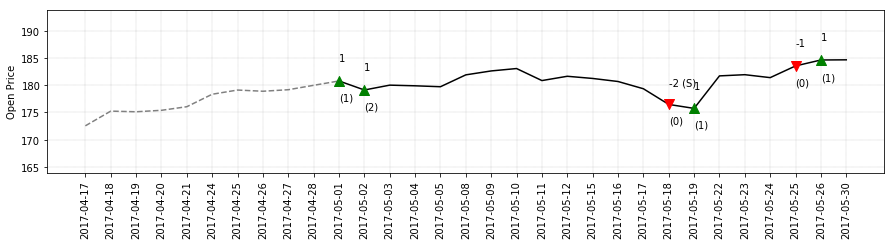

Return: 1.082
Random return: 1.041


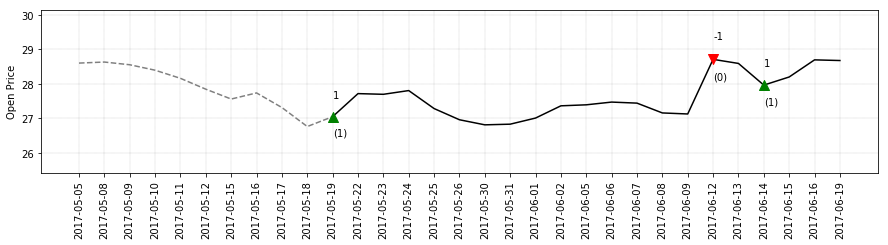

Return: 1.150
Random return: 0.967


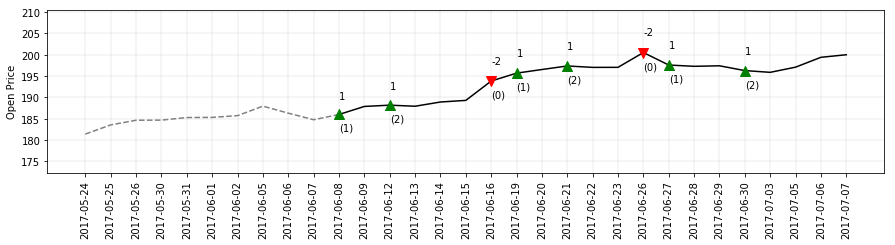

Return: 1.220
Random return: 1.092


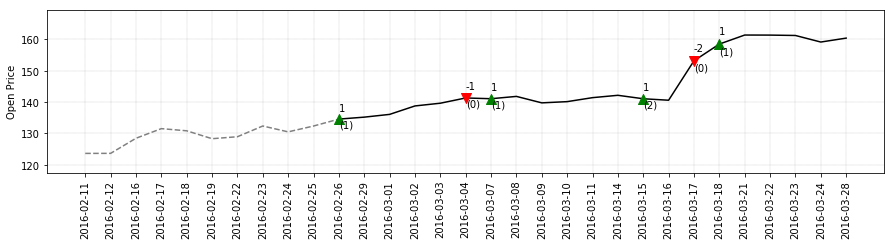

Return: 1.079
Random return: 0.879


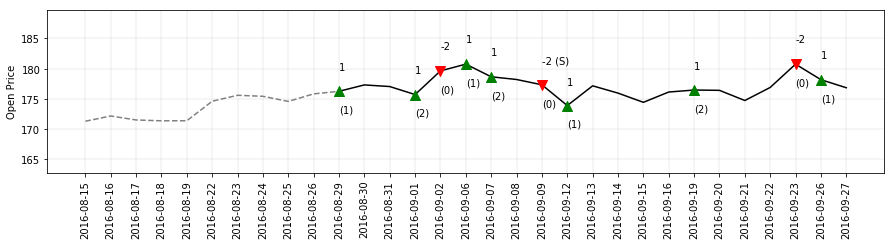

Return: 1.048
Random return: 0.945


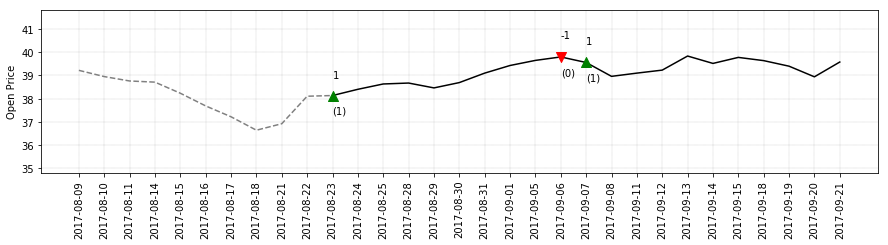

Return: 1.041
Random return: 0.958


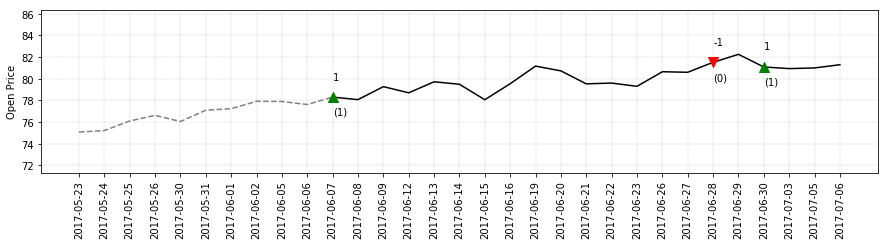

Return: 1.000
Random return: 0.979


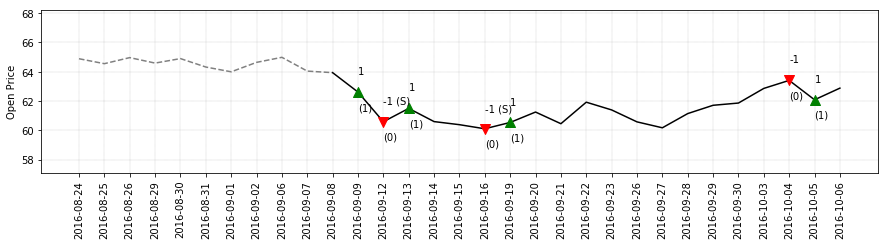

Return: 1.111
Random return: 1.060


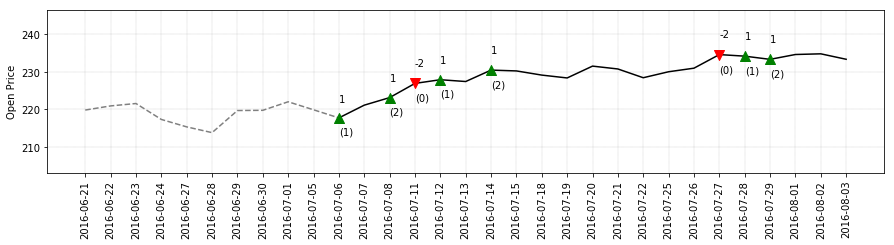

Return: 0.831
Random return: 0.870


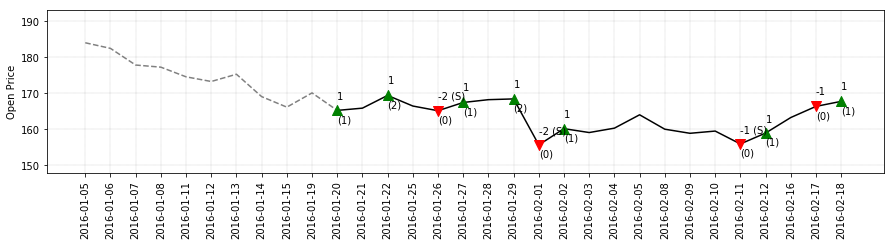

Return: 0.940
Random return: 0.978


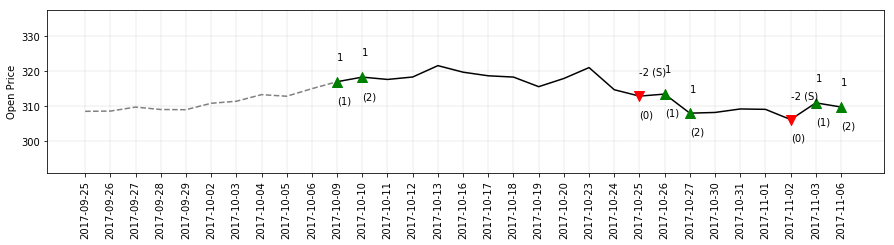

Return: 1.032
Random return: 0.858


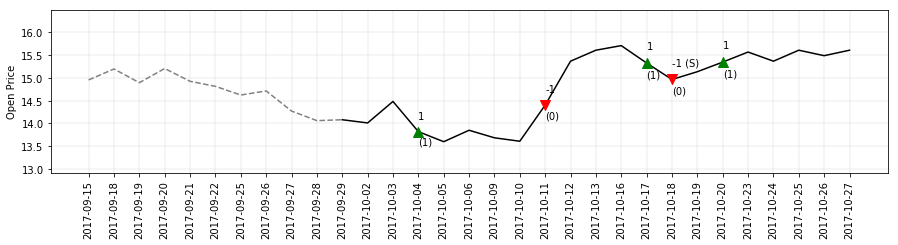

Return: 1.032
Random return: 1.013


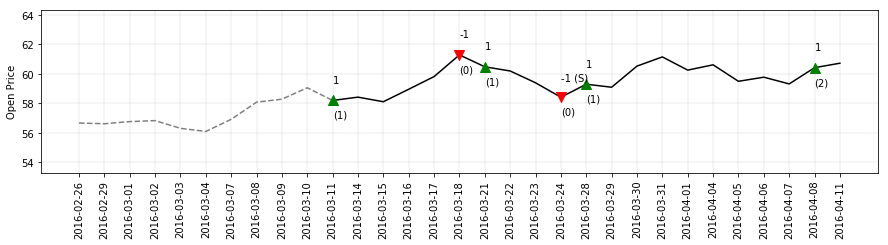

Return: 1.053
Random return: 1.047


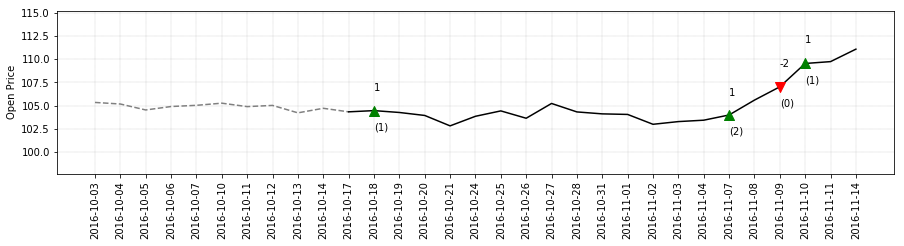

Return: 1.056
Random return: 1.042


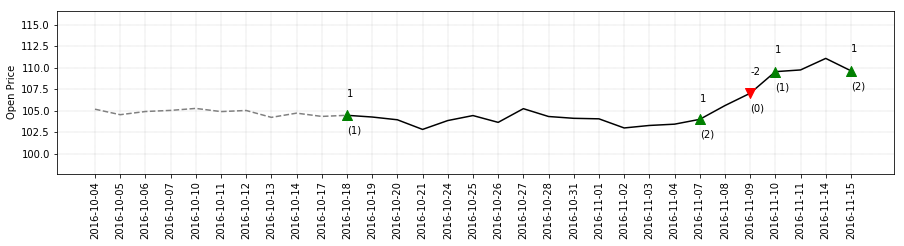

Return: 0.980
Random return: 1.006


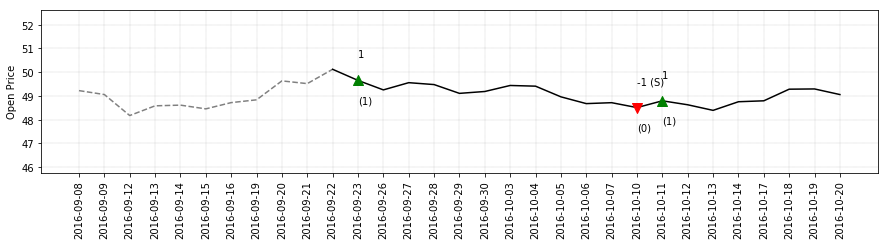

Return: 1.018
Random return: 1.016


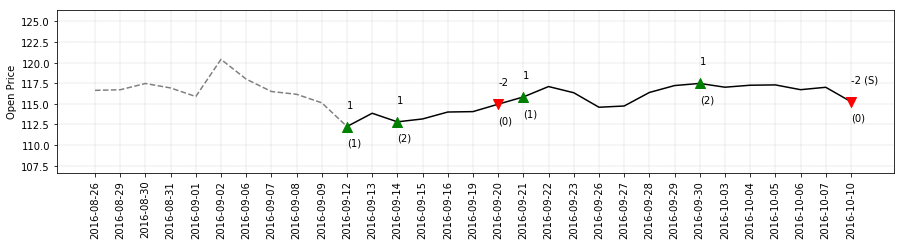

Return: 1.072
Random return: 1.030


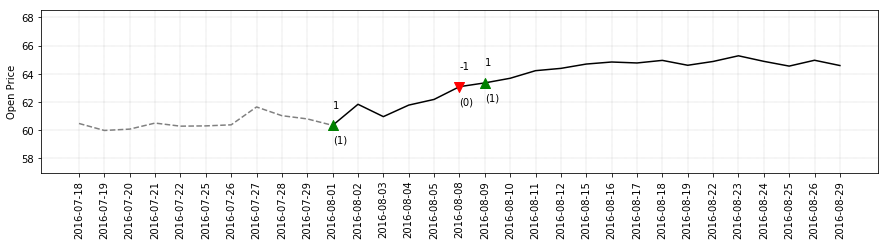

Return: 0.953
Random return: 1.057


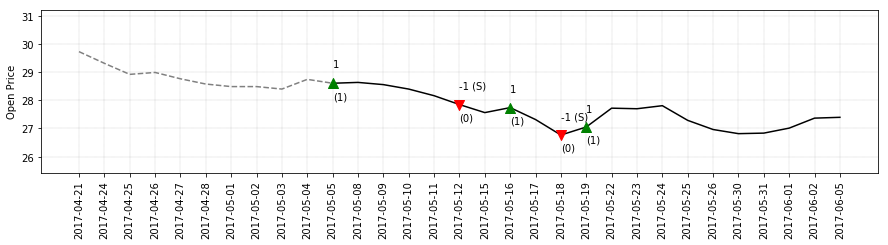

Return: 1.134
Random return: 0.899


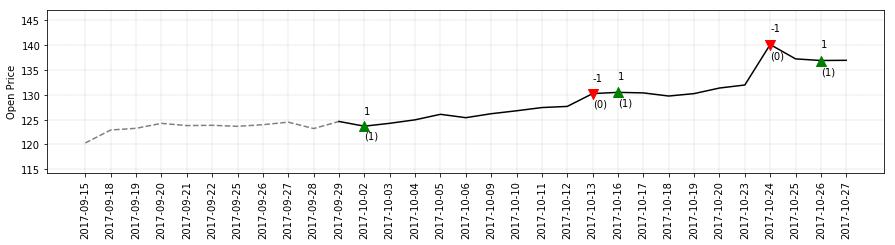

Return: 0.973
Random return: 0.933


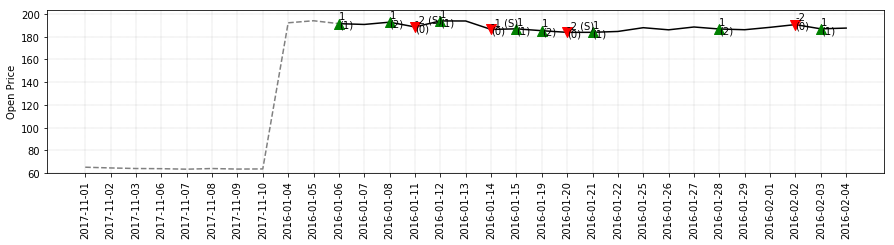

In [77]:
episode_count = 150

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data_test,verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [78]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (150 episodes): 1.014
Average random return (150 episodes): 0.989
